<a id='root'></a>
![Project Logo](Project_Logo.pdf)

PyUltraLight 2.18.5

(1 Apr 2021)

* Y. Wang: [yourong.f.wang@auckland.ac.nz](mailto:yourong.f.wang@auckland.ac.nz)
* R. Easther
***



<a id='init'></a>
# Initialization and Program Settings

## Loading Packages



In [ ]:
%reset

In [ ]:
###### Do not touch
MinVersion = 18

import PyUltraLight_NBody_18 as PyUL

if (PyUL.S_version < MinVersion):
    raise RuntimeError("You need the latest PyULN!")

import numpy as np
np.set_printoptions(suppress=True)

import math

import numba
import numexpr as ne
import time
import pyfftw
import os
import sys
import multiprocessing
import numpy

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec
import matplotlib.animation
from matplotlib.offsetbox import AnchoredText

import scipy.fft

import h5py
from IPython.core.display import clear_output, display

%reload_ext autoreload
%autoreload 2
%matplotlib inline

ToCode = PyUL.convert
ToPhys = PyUL.convert_back
CB = PyUL.convert_between

## Visualization Preferences
Initialize the colors of black holes, contours, and energy lines.

### For Science

In [ ]:
mpl.style.use('default')

mpl.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

Palette = 'magma'
CycPalette = 'Greys'
DivPalette = 'RdYlGn'

FPS = 6
########################################
## Defines Visualization Colors, v0.25
# BH Trajectory

Colors = np.array([[209,17,65],[0,177,89],[0,174,219],[243,119,53],[255,196,37]])/255

# NBody
ENStyle = '-.'
ENColor = '#cfaf8a' # NBody

EKColor = '#cf838a'
EPColor = '#8acf99'

# ULDM
EUStyle = '--'
EUColor = '#8d4b66' # ULDM

EQColor = '#4d7e4e' # Kinetic 
ERColor = '#545b7e' # Self-Interaction
EGColor = '#69567c' # Particle Potential

# Totals
ETStyle = '-'
ETColor = '#272727'

# Auxiliary 
HelperStyle = 'k.'

### Cinematic

In [ ]:
Palette = 'magma'
CycPalette = 'twilight'
mpl.style.use('dark_background')
########################################
## Defines Visualization Colors, v0.25
# BH Trajectory

Colors = np.array([[209,17,65],[0,177,89],[0,174,219],[243,119,53],[255,196,37]])/255

FPS = 60
# NBody
ENStyle = '--'
ENColor = '#cfaf8a' # NBody

EKColor = '#cf838a'
EPColor = '#8acf99'

# ULDM
EUStyle = '-.'
EUColor = '#8d4b66' # ULDM

EQColor = '#4d7e4e' # Kinetic 
ERColor = '#545b7e' # Self-Interaction
EGColor = '#69567c' # Particle Potential

# Totals
ETStyle = '-'
ETColor = '#a7a7a7'

# Auxiliary 
HelperStyle = 'w.'

[**<font color=blue>Back to the Top</font>**](#root)
<a id='ULSettings'></a>
# PyULN Parameters

In [ ]:
##================================================================
# Snapshot Settings A
save_number = 180

start_time = 0.
# Recommended Save Number Cap: 120
# Depending on resolution, this could require significant disk space.

# Runge-Kutta Steps for NBody
NS = 16 # 1,4,8,16,... NBody Integration Steps per ULD Step. 1 -> Euler


# Default Resolution
resol = 128
# Fixed Resolution
FixResol = False
resolMax = 512
resolDen = 32 # Mesh Grids Per Code Unit

#Formats to save
hdf5 = False
npz = False
npy = True

#Data to save
#0
save_rho = False # Saves density data for entire 3D simulation grid

#1
save_psi = False # Saves ULD Phase Data in plane

#2
save_plane = True # Saves density data for plane z = 0

#3
save_energies = True # Saves integrated gravitational, kinetic and total energies as lists

#4
save_line = False # Saves density data for line y = 0, z = 0. Useful for examining intereference patterns.

#5
save_testmass = True # Saves trajectory and 3-velocity of a test mass thrown into the system. 

#6
save_phi = False

#7
save_phi_plane = True

#8
save_gradients = True

#9
save_phase_plane = True

save_options = [save_rho,save_psi,save_plane,save_energies,save_line,save_testmass,save_phi,save_phi_plane,save_gradients,save_phase_plane]


SaveSizeEstimate = PyUL.SSEst(save_options,save_number,resol)

print('Estimated Save Size (GiB): %.03f' % SaveSizeEstimate )

#================================================================
# Do not touch
resol = (scipy.fft.next_fast_len(resol)) # Uses a nearby and faster resolution.
while resol%2:
    resol = scipy.fft.next_fast_len(resol+1)
    print(resol)
num_threads = multiprocessing.cpu_count()
print("Available CPU threads for this run: ",num_threads)

[**<font color=blue>Back to the Top</font>**](#root)
<a id='demos'></a>
# Scenarios


<a id='demo_elli'></a>
## Example 1: 2Body Elliptical Orbit

In [ ]:
resol = 128

length = 8 # 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
duration = 5 #1 code unit is ~70 Gyr (independent of axion mass assumption)

step_factor = 1

length_units = '' 
duration_units = '' 
s_mass_unit = ''
s_position_unit = '' 
s_velocity_unit = '' 
m_mass_unit = ''
m_position_unit = ''
m_velocity_unit = ''

m1 = 3 # User Input
Ratio1 = 1

m2 = 20 # User Input
Ratio2 = 0

Aphelion = 4 # User Input

e = 0.37 # Eccentricity. 0 -> Circle. 1 -> Parabola. 

#================================================================
# Do not touch

M = m1 + m2
xC = Aphelion

## Simulation always starts from Aphelion, in Centre-of-mass Frame

x2 = xC * m1/M # Bigger Mass, Smaller Initial Position
x1 = xC - x2

a1 = x1 / (1+e) # Semimajor Axis from Aphelion
a2 = x2 / (1+e)

xPeri1 = a1*(1-e)
xPeri2 = a2*(1-e)

## Initial Velocity is purely tangential.

yDot1 = np.sqrt(m2*x1/xC**2*(1-e)/(1+e))
yDot2 = np.sqrt(m1*x2/xC**2*(1-e)/(1+e))

particles = []
solitons = []

Halo1 = [m1, [x1,0,0], [0,yDot1,0],Ratio1,0]
Halo2 = [m2, [-x2,0,0], [0,-yDot2,0],Ratio2,0]

embeds = [Halo1,Halo2]

########### MODIFIER PARAMETERS
# Removes all ULDM Structures defined elsewhere in the IV and replaces them with a uniform wavefunction 
# with given probability amplitude (code unit).

Uniform = True
Density = 1e3


if not Uniform:
    print('The List of Soliton Conditions is:')
    print(solitons)
    
print('The List of BH Conditions is:')  
print(particles)

print('The List of Embedded Conditions is:')  
print(embeds)

In [ ]:
resol = 128

length = 5 # 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
duration = 4 #1 code unit is ~70 Gyr (independent of axion mass assumption)

step_factor = 1

length_units = '' 
duration_units = '' 
density_unit = ''
s_mass_unit = ''
s_position_unit = '' 
s_velocity_unit = '' 
m_mass_unit = ''
m_position_unit = ''
m_velocity_unit = ''

m1 = 30 # User Input
m2 = 20 # User Input

Ratio1 = 1
Ratio2 = 1


Aphelion = 1 # User Input

e = 0.133 # Eccentricity. 0 -> Circle. 1 -> Parabola. 

#================================================================
# Do not touch

M = m1 + m2
xC = Aphelion

## Simulation always starts from Aphelion, in Centre-of-mass Frame

x2 = xC * m1/M # Bigger Mass, Smaller Initial Position
x1 = xC - x2

a1 = x1 / (1+e) # Semimajor Axis from Aphelion
a2 = x2 / (1+e)

xPeri1 = a1*(1-e)
xPeri2 = a2*(1-e)

## Initial Velocity is purely tangential.

yDot1 = np.sqrt(m2*x1/xC**2*(1-e)/(1+e))
yDot2 = np.sqrt(m1*x2/xC**2*(1-e)/(1+e))


particles = []
solitons = []

Halo1 = [m1, [x1,0,0], [0,yDot1,0],Ratio1,0]
Halo2 = [m2, [-x2,0,0], [0,-yDot2,0],Ratio2,0]

embeds = [Halo1,Halo2]

########### MODIFIER PARAMETERS
# Removes all ULDM Structures defined elsewhere in the IV and replaces them with a uniform wavefunction 
# with given probability amplitude (code unit).

Uniform = False
Density = 4e10
UVel = [0,0,0] # Uses s_velocity_units


if not Uniform:
    print('The List of Soliton Conditions is:')
    print(solitons)
    
print('The List of BH Conditions is:')  
print(particles)

print('The List of Embedded Conditions is:')  
print(embeds)

[**<font color=green>Go to Execution</font>**](#run)
<a id='demo_scatter'></a>
## Example 2: 2Body Scattering

In [ ]:
resol = 128

length_units = '' 
duration_units = '' 
s_mass_unit = ''
s_position_unit = '' 
s_velocity_unit = '' 

length = 6 #
duration = 1 #

step_factor = 1 # Large number to save sanity.

m1 = 40 # User Input
m2 = 8 # User Input


PyUL.SolitonSizeEstimate(m1,length,resol,s_mass_unit,length_units)

Ratio1 = 0
Ratio2 = 1

Phase = 0 # Multiples of pi

b = 0.71 # Impact Parameter

vRel0 = 6.0 # Initial Speed along Collision Axis

Separation = 1.5


Uniform = False # if True, then there won't be solitons.
Density = 0
UVel = [0,0,0] # Uses s_velocity_units
density_unit = '' # Accepted units: 'MSol/pc3', 'kg/m3', and '' for dimensionless units

m_mass_unit = s_mass_unit
m_position_unit = s_position_unit
m_velocity_unit = s_velocity_unit



#================================================================
# Do not touch

# Unit 1
y1 = Separation*m2/(m1+m2)
x1 = b*m2/(m1+m2)
yDot1 = vRel0*m2/(m1+m2)


# Unit 2
y2 = Separation*m1/(m1+m2)
x2 = b*m1/(m1+m2)
yDot2 = vRel0*m1/(m1+m2)


particles = []
solitons = []
embeds = [] 

Composite1 = [m1,[x1,y1,0],[0,-yDot1,0],Ratio1,Phase*np.pi/2]
Composite2 = [m2,[-x2,-y2,0],[0,yDot2,0],Ratio2,-Phase*np.pi/2]
embeds.append(Composite1)
embeds.append(Composite2)


print(particles,solitons,embeds,sep='\n\n')

[**<font color=green>Go to Execution</font>**](#run)
<a id='demo_tya'></a>
## Example 3: 4Body Tangyuan

In [ ]:
resol = 64
length = 12# 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
duration = 5 #1 code unit is ~70 Gyr (independent of axion mass assumption)

step_factor = 1

length_units = '' 
duration_units = '' 
s_mass_unit = ''
s_position_unit = '' 
s_velocity_unit = '' 
m_mass_unit = ''
m_position_unit = ''
m_velocity_unit = ''

# Density, if Uniform Background Flag is Set to 'True'
# 1 Code Density Unit is equal the universe's critical matter density, 2.67e-27 kg/m^3.
density_unit = '' # Accepted units: 'MSol/pc3', 'kg/m3', and '' for dimensionless units

r = 1.4
m = 20

Ratio = 1

v = np.sqrt(m/r*(1+2*np.sqrt(2)))/2

vM = 1 # Change Magn. 

#================================================================
# Do not touch

v = vM * v
print("The initial tangential speed is %.4f \n" % (v))

Halo1 = [m,[r,0,0],[0,v,0],Ratio,0]
Halo2 = [m,[0,r,0],[-v,0,0],Ratio,0]
Halo3 = [m,[-r,0,0],[0,-v,0],Ratio,0]
Halo4 = [m,[0,-r,0],[v,0,0],Ratio,0]

embeds = [Halo1, Halo2, Halo3, Halo4]
#Soliton parameters are mass, position, velocity and phase (radians)

solitons = []
#particles = [[6,[-3,-3,0],[5,5,0]]]
particles = []

Uniform = False
Density = 0.05
UVel = [0,0,0] # Uses s_velocity_units

if Uniform:
    embeds = []
    BH1 = [m,[r,0,0],[0,v,0]]
    BH2 = [m,[0,r,0],[-v,0,0]]
    BH3 = [m,[-r,0,0],[0,-v,0]]
    BH4 = [m,[0,-r,0],[v,0,0]]
    particles = [BH1, BH2, BH3, BH4]


[**<font color=green>Go to Execution</font>**](#run)
<a id='demo_QM'></a>
## Example 4: Merger From Rest

In [ ]:
resol = 128

length = 1 # 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
duration = 0.002 #1 code unit is ~70 Gyr (independent of axion mass assumption)

SimL = length/4  # Simulation Starting Region

step_factor = 1

NEmbed = 2

RandomSeed = 5

###
np.random.seed(RandomSeed)

length_units = '' 
duration_units = '' 
s_mass_unit = ''
s_position_unit = '' 
s_velocity_unit = '' 
m_mass_unit = ''
m_position_unit = ''
m_velocity_unit = ''

MassMax = 800 #
MassMin = 600

RatioMax = 0.1
RatioMin = 0.


#================================================================
# Do not touch

embeds = []
particles = []

for i in range(NEmbed):
    Location = ([(np.random.random()-1/2)*SimL/2,(np.random.random()-1/2)*SimL/2,0])
    
    Speed = 0.5*np.random.random()
    
    Angle = 2*np.pi*np.random.random()
    
    Velocity = [Speed*np.cos(Angle),Speed*np.sin(Angle),0]
    
    Ratio = RatioMax
    
    Mass = MassMin + np.random.random()*(MassMax-MassMin)
    
    Phase = np.pi*(np.random.random())/2
    
    embeds.append([Mass,Location,Velocity,Ratio,Phase])
    


solitons = []

Uniform = False
Density = 0
UVel = [0,0,0] # Uses s_velocity_units
density_unit = '' # Accepted units: 'MSol/pc3', 'kg/m3', and '' for dimensionless units
print(*embeds, sep = "\n")

# print(*particles, sep = "\n")

[**<font color=green>Go to Execution</font>**](#run)
<a id='demo_QM'></a>
## Example 5: Dwarf Galaxies

In [ ]:
resol = 128

length = 16# 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
duration = 10 #1 code unit is ~70 Gyr (independent of axion mass assumption)

step_factor = 5

NStar = 15 # Test stars per galaxy

RIn = 1
ROut = 2.3
RBaseline = 20 # Smaller galaxies are denser in stars.
MaxStarMass = 0

RandomSeed = 950209

###
np.random.seed(RandomSeed)

length_units = '' 
duration_units = '' 
s_mass_unit = ''
s_position_unit = '' 
s_velocity_unit = '' 
m_mass_unit = ''
m_position_unit = ''
m_velocity_unit = ''



embeds = [[8,[0,-3,0],[-0.03,0.375,0],1,np.pi],[12,[0,2,0],[0.02,-0.25,0],1,0]]

particles = []

def FOSR(m,r):
    return np.sqrt(m/r)

#================================================================
# Do not touch

for j in range(len(embeds)):
    
    Galaxy = embeds[j]
    
    GPos = np.array(Galaxy[1])
    GVel = np.array(Galaxy[2])
    GMass = Galaxy[0]
    
    RFac = GMass/20
    
    NStarL = np.random.randint(-2, 4)
    for i in range(NStar+NStarL):

        r = (np.random.random()*(ROut-RIn) + RIn)*GMass/RBaseline
        
        theta = 2*np.pi*np.random.random()
        v = FOSR(GMass,r)

        Position = np.array([r*np.cos(theta),r*np.sin(theta),0]) + GPos
        Velocity = np.array([v*np.sin(theta),-v*np.cos(theta),0]) + GVel
        
        Mass = MaxStarMass*np.random.random()
        
        particles.append([Mass,Position.tolist(),Velocity.tolist()])


solitons = []

Uniform = False
Density = 0
UVel = [0,0,0] # Uses s_velocity_units
density_unit = '' # Accepted units: 'MSol/pc3', 'kg/m3', and '' for dimensionless units
print(*embeds, sep = "\n")

print(*particles, sep = "\n")

## [Dynamical Friction with Soliton]

In [ ]:
resol = 128

# Space Settings
length = 1 # 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
length_units = 'kpc'  # Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units.

# Time Settings
duration = 4 #1 code unit is ~70 Gyr (independent of axion mass assumption)
duration_units = 'Myr'  # Accepted units: 's', 'yr', 'kyr', 'Myr', and '' for dimensionless units

step_factor = 1

# Recommended Save Number Cap: 120
# Depending on resolution, this could require significant disk space.

##================================================================
## Other Flags
# Set units for soliton parameters
s_mass_unit = 'M_solar_masses'    #Accepted units: 'kg', 'solar_masses', 'M_solar_masses', and '' for dimensionless units
s_position_unit = 'kpc' #Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units
s_velocity_unit = 'km/s' #Accepted units: 'm/s', 'km/s', 'km/h', 'c', and '' for dimensionless units

# Rules ditto.
m_mass_unit = 'M_solar_masses'
m_position_unit = 'kpc'
m_velocity_unit = 'km/s'


dBL = PyUL.convert_between(PyUL.DefaultDBL(v = 1e6),'m',length_units,'l')

if dBL >= length:
    print(f'Not Good! Nominal de Broglie wavelength of axion: {dBL}{length_units} ')
    

mS = 3000 # User Input
mP = 10 # User Input

Ratio1 = 0.0
Ratio2 = 0.0


Uniform = False # if True, then there won't be solitons.
Density = 0
UVel = [0,0,0] # Uses s_velocity_units
density_unit = '' # Accepted units: 'MSol/pc3', 'kg/m3', and '' for dimensionless units

embeds = []

solitons = [[mS,[0,0,0],[0,0,0],0]]

particles = [[mP,[0,-0.38,0],[0,50,0]]]

PyUL.SolitonSizeEstimate(mS,length,resol,s_mass_unit,length_units)

[**<font color=green>Go to Execution</font>**](#run)
<a id='demo_byo'></a>
## [Dynamical Friction with Uniform Background]

In [ ]:
######## USER PARAMETERS BELOW ################################

speed, s_velocity_unit = (10,'km/s')

QuantumWind = False # Galileo Switch
Automatic = True

BHSpeedMultiplier = 0 # 1 = Comoving, -1 = Against, 0 = Stationary 

length_units = 'kpc'

duration = 3000 #1 code unit is ~70 Gyr (independent of axion mass assumption)
duration_units = 'Myr'  # Accepted units: 's', 'yr', 'kyr', 'Myr', and '' for dimensionless units


NdB = 4 # Number of deBroglie wavelengths that fit in the simulation

mBH1, m_mass_unit = 1 , 'M_solar_masses'

######## PRESET PARAMETERS BELOW ################################

# de Broglie in Lab Frame is the Quantum Wind wavelength

if speed == 0:
    lbasic = 1
else:
    lbasic = PyUL.convert_back(np.pi*2/PyUL.convert(speed,s_velocity_unit,'v'),length_units,'l')

rPB = 32 # Resolution per full matter wavelength.

resol = NdB*rPB # 32 looks like it's a good fit

print(f'Quantum de Broglie wavelength: {lbasic:.4g} {length_units}')

length = NdB*lbasic # Can be changed to fit more wavelengths.


MaxDuration = CB((CB(length,length_units,'m','l')/CB(speed,s_velocity_unit,'m/s','v')),'s',duration_units,'t')
print(f'Maximum allowed duration: {MaxDuration:.1f} {duration_units}')

if Automatic:
    duration = MaxDuration/2

print(f'Simulation domain edge length: {length:.4g} {length_units}')

Uniform = True
Density = 3e9  # 1 Code unit is 0.31*Critical Density

##================================================================
## Other Units
# Set units for soliton parameters
    
s_position_unit = length_units
m_position_unit = length_units
m_velocity_unit = s_velocity_unit

s_mass_unit = ''
density_unit = ''
# 1 Code Density Unit is equal the universe's critical matter density, 2.67e-27 kg/m^3.
 # Accepted units: 'MSol/pc3', 'kg/m3', and '' for dimensionless units

##================================================================

if QuantumWind:
    
    particles = [[mBH1,[0,length/4,0],[0,-speed*BHSpeedMultiplier,0]]]

    solitons = []

    embeds = []

    UVel = [0,-speed,0] 
    
else:

    particles = [[mBH1,[0,-length/4,0],[0,speed,0]]]

    solitons = []

    embeds = []

    UVel = [0,0,0]




[**<font color=green>Go to Execution</font>**](#run)
<a id='demo_byo'></a>
# Build Your Own


## How to create new objects.

* **Particle Config: ** 
```python
[mass,[position],[velocity]]
```

* **Soliton Config: **
```python
[mass,[position],[velocity],phase]
```

* **Embedded Soliton Config: **
```python
[total_mass,[position],[velocity],mBH/total_mass,phase]
```

* **Uniform Wavefront (Previously QuantumWind): **

```python
UVel
```
* **Nonvanishing Dispersion: **


**NOTE**: Embedded solitons and Uniform backgrounds inherit the soliton units setting.

In [ ]:
resol = 256
# Space Settings
length = 15 # 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
length_units = 'kpc'  # Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units.

# Time Settings
duration = 8e-6 #1 code unit is ~70 Gyr (independent of axion mass assumption)
duration_units = ''  # Accepted units: 's', 'yr', 'kyr', 'Myr', and '' for dimensionless units

step_factor = 1

# Recommended Save Number Cap: 120
# Depending on resolution, this could require significant disk space.

##================================================================
## Other Flags
# Set units for soliton parameters
s_mass_unit = ''     #Accepted units: 'kg', 'solar_masses', 'M_solar_masses', and '' for dimensionless units
s_position_unit = '' #Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units
s_velocity_unit = '' #Accepted units: 'm/s', 'km/s', 'km/h', 'c', and '' for dimensionless units

# Rules ditto.
m_mass_unit = 'M_solar_masses'
m_position_unit = 'kpc'
m_velocity_unit = 'm/s'

# Density, if Uniform Background Flag is Set to 'True'
# 1 Code Density Unit is equal the universe's critical matter density, 2.67e-27 kg/m^3.
density_unit = '' # Accepted units: 'MSol/pc3', 'kg/m3', and '' for dimensionless units

##================================================================

mBH1 = 1

BH1 = [mBH1,[0,-0.3,0],[0,9e4,0]]

particles = [BH1]

soliton1=[2000,[0,0,0],[0,0,0],-0]

solitons = [soliton1]

embeds = []

########### MODIFIER PARAMETERS

# Removes all ULDM Structures defined elsewhere in the IV and replaces them with a uniform wavefunction 
# with given probability amplitude (code unit).

Uniform = False
Density = 4e10
UVel = [0,0,0] # Uses s_velocity_units
#Density = 0


if not Uniform:
    print('The List of Soliton Conditions is:')
    print(solitons)
    print('The List of Embedded Soliton Conditions is:')  
    print(embeds)
    
print('The List of BH Conditions is:')  
print(particles)



[**<font color=blue>Back to the Top</font>**](#root)
<a id='run'></a>
# Compiling and Go

This creates a timestamped folder using the current settings, and the integrator stores all requested files in it too.

## <font color=green>Gravitational Field Smoothing</font>
Instead of coding in the idealistic $\frac{m}{r}$ potential, we approximate it with a Plummer sphere. 

The modified potential is a useful approximation of a point mass in a distance, and puts an exponential cap on the infinite potential well, which reduces the impact of numerical artefacts.


The smoothing factor, $a$, is also defined here.


The differences between the two potentials are characterised in the program output box.

In [ ]:
lengthC = PyUL.convert(length, length_units, 'l')

GridlenC = lengthC/(resol)

print(f"The grid subdivision is {length/resol:.4f} in specified units. This is {GridlenC:.4f} code units.")

central_mass = 0 # Not Implemented Anymore. Keep for backwards compatibility.
#================================================================
a = (2-PyUL.LW(np.exp(-2)))/lengthC*resol
a = np.real(a)/3
# Field Cut-off Factor
#================================================================
#Specify b, the distance beyond which ULDM field does not feel the NBody. Version 1
B = 0 # As Multiples of Gridlength. 0 = Off.

print(f"The Smoothing factor is {a:.3f}")

print(f"That means the particle characteristic length is {1/ToCode(a,length_units,'l'):.4g}{length_units}")

## Single Simulation

In [214]:
save_path = '2021April'

PyUL.DSManagement(save_path)

2021April : The current size of the folder is 2670.043 Mib
2021April : Do You Wish to Delete All Files Currently Stored In This Folder? [Y] 





In [128]:
duration = 5000

resol = 128

step_factor = 1

PyUL.DispN(duration,duration_units,length,length_units,resol,step_factor)

The expected number of ULDM steps is 9


In [125]:
NoInteraction = False
Name = ''

#Draft = True # Soliton Resolution Switch. Production Resol: 1e-5, Draft: 1e-3.
#EdgeClear = False # Clear Edge (Rudimentary Sponge)
#DumpInit = False # Dump Initial Conditions into ChplUltra-compliant Files
#IsoP = False # Use Isolated Potential
#UseDispSponge = False # Use Dispersive Sponge (Default Setting: Sponge Thickness = 1/4*L)
#NBodyInterp = False
#SelfGravity = True

run_folder = PyUL.GenerateConfig(NS, central_mass, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_path, npz, npy, hdf5, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles,embeds, Uniform,Density,density_unit,a,B,UVel,NoInteraction,Name)

PyUL.evolve(save_path,run_folder, DumpInit = False,
            EdgeClear = False, IsoP = False, UseDispSponge = False,
            NBodyInterp = True ,SelfGravity = False, NBodyGravity = True) 

import IPython
IPython.display.Audio("Done.mp3",autoplay=True)

[●●●●●●●●●●●●●●●●●●●●●●●●●] 100% Expected Finish Time: 02/04/2021, 20:35:44 (Prev. Step: 1.50s)60s)

PyUL2 Runtime: Run Complete. Time Elapsed (d:h:m:s): 0:0:15:35.35


## Parameter Scanning (Batch Execution)

Please refer to the separate 'ParamScan' notebook for effective parameter scanning analysis.

In [226]:
save_path = '2021April'

ExperimentName = '/DynFnP1'

save_path += ExperimentName

PyUL.DSManagement(save_path)

2021April/DynFnP1 : The current size of the folder is 0.04 Mib
2021April/DynFnP1 : Do You Wish to Delete All Files Currently Stored In This Folder? [Y] 

Y
Folder Cleaned! 

2021April/DynFnP1 : Save Folder Created.


In [227]:
baseConfig = '2021April' # Path to base config file. It won't be touched.

# Currently supported scan parameters: Density, Resolution, TM_Mass, TM_vY, UVelY, Step_Factor, Scaling

ScanParams = ['Density','TM_Mass','Resolution','Scaling']

ValuePool = [[300,1000,3000,10000],[1,10],[128],[0.25,0.5]]

PyUL.ParameterScanGenerator(baseConfig,ScanParams,ValuePool,save_path)

Automated scan will be performed over 4 parameters.
There will be 16 separate simulations. They are:
[('Density', [300, 1000, 3000, 10000]), ('TM_Mass', [1, 10]), ('Resolution', [128]), ('Scaling', [0.25, 0.5])]
(Units are defined in the donor config file)
Generated config file for ParamScan-DS01-TM01-RS01-SC01
Generated config file for ParamScan-DS01-TM01-RS01-SC02
Generated config file for ParamScan-DS01-TM02-RS01-SC01
Generated config file for ParamScan-DS01-TM02-RS01-SC02
Generated config file for ParamScan-DS02-TM01-RS01-SC01
Generated config file for ParamScan-DS02-TM01-RS01-SC02
Generated config file for ParamScan-DS02-TM02-RS01-SC01
Generated config file for ParamScan-DS02-TM02-RS01-SC02
Generated config file for ParamScan-DS03-TM01-RS01-SC01
Generated config file for ParamScan-DS03-TM01-RS01-SC02
Generated config file for ParamScan-DS03-TM02-RS01-SC01
Generated config file for ParamScan-DS03-TM02-RS01-SC02
Generated config file for ParamScan-DS04-TM01-RS01-SC01
Generated confi

'2021April/DynFnP1'

In [235]:
runs = os.listdir(save_path)
runs.sort()

Run = 0
for run_folder in runs:
    
    if os.path.isdir(f'{save_path}/{run_folder}'):
        PyUL.evolve(save_path,run_folder, DumpInit = False,
            EdgeClear = False, IsoP = False, UseDispSponge = False,
            NBodyInterp = False ,SelfGravity = False, NBodyGravity = True, 
            Silent = True) 

    
        Run +=1
        print(f'Simulation {Run} finished.')
    

==========PyUL Version 2.18.6: Integrator Build 2021 04 01==========
Pre-existing Output files removed.
PyUL2 IO: Loaded Parameters from ./2021April/DynFnP1/ParamScan-DS04-TM02-RS01-SC02
PyUL2 NBody: Using Linear Interpolation for gravity.
PyUL2 SP: Simulation grid resolution is 128^3.
PyUL2 NBody: The point mass field smoothing factor is 18.33662.
PyUL2 SP: NBody Gravity ENABLED.
PyUL2 SP: ULDM Self-Gravity DISABLED.
PyUL2 SP: NBody Interpolation for ULDM Potential DISABLED.
PyUL2 Init: Solitons overridden with a uniform wavefunction with no phase.
PyUL2 Init: Total ULDM mass in domain is 10137048.5127. This is 10000.0000 per grid.
PyUL2 SP: Poisson Equation Solveed Using FFT.
PyUL2 NBody: Particle #0 loaded, with (code) mass 4.489
PyUL2 NBody: The initial state vector is:
[[0.         2.51136893 0.         0.         0.         0.        ]]
PyUL2 IO: Successfully initiated Wavefunction and NBody Initial Conditions.
PyUL2 Runtime: Simulation Started at 02/04/2021, 22:39:05.
PyUL2 Runt

## Loading Data and Config

In [236]:
TimeStamp = PyUL.Runs(save_path)
clear_output()
loc = './' + save_path + '/' + TimeStamp
print(loc,'\n')
# Reload Config
NS, central_mass, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, npz, npy, hdf5, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles, embeds, Uniform,Density, density_unit ,a, B, UVel = PyUL.LoadConfig(loc)

# Reload Output

EndNum, data, TMdata, phidata, graddata, phasedata = PyUL.Load_Data(save_path,TimeStamp, save_options,save_number)

NBo = len(particles)

ToCode = PyUL.convert
ToPhys = PyUL.convert_back
CB = PyUL.convert_between

# Time
durationMyr = ToPhys(ToCode(duration,duration_units,'t'),'Myr','t') * (EndNum-1) / save_number

# Space
lengthKpc = CB(length,length_units,'kpc','l')
lengthC = ToCode(length,length_units,'l')

'''
if NBo != 0:
    dBL = PyUL.convert_between(PyUL.DefaultDBL(v = particles[0][2][1],vUnit = m_velocity_unit),'m',length_units,'l')/(2*np.pi)
else:
    dBL = PyUL.convert_between(PyUL.DefaultDBL(v = 10,vUnit = 'km/s'),'m',length_units,'l')/(2*np.pi)
'''

# Mass

MassList_MSol = []
MassListSI = []
for TM in particles:
    MassList_MSol.append(CB(TM[0],m_mass_unit,'M_solar_masses','m'))
    MassListSI.append(CB(TM[0],m_mass_unit,'kg','m'))
    
# Density
densitySI = ToPhys(ToCode(Density,density_unit,'d'),'kg/m3','d')

## Misc. Pre-Multipliers

# NBody_State Vector

XPre = ToPhys(1,'kpc','l')
VPre = ToPhys(1,'km/s','v')

XPreSI = ToPhys(1,'m','l')
VPreSI = ToPhys(1,'m/s','v')

IArray = np.arange(len(TMdata[0]))

# Dimensionful NBody State

TMDataS = np.array(TMdata)
TMDataSI = np.array(TMdata)

TMDataS[:,IArray % 6 <= 2] *= XPre
TMDataS[:,IArray % 6 >= 3] *= VPre

TMDataSI[:,IArray % 6 <= 2] *= XPreSI
TMDataSI[:,IArray % 6 >= 3] *= VPreSI


# Rho data

DPre = ToPhys(1,'kg/m3','d')

# Energy
EPre = PyUL.energy_unit

# Field Strength
PPre = PyUL.mass_unit / PyUL.length_unit


print('Unit conversion ready!')


print("==============================================")
print(f"PyULN: Axion Mass Used is {PyUL.axion_E} eV.\n")

print(f"\
1 Mass Unit    = {PyUL.mass_unit:.5g} kg = {PyUL.convert_back(1,'solar_masses','m'):.4g} MSol\n\
1 Length Unit  = {PyUL.length_unit:.5g} m  = {PyUL.convert_back(1,'kpc','l'):.4g} kpc\n\
1 Time Unit    = {PyUL.time_unit:.5g} s  = {PyUL.convert_back(1,'Myr','t')/1000:.4g} Gyr\n\n\
1 Density Unit = {PyUL.mass_unit/PyUL.length_unit**3:.5g} kg/m^3 = {PyUL.mass_unit/PyUL.length_unit**3/PyUL.CritDens} Critical Density\n\
1 Speed Unit   = {PyUL.length_unit/PyUL.time_unit:.5g} m/s\n\
1 Energy Unit  = {EPre:.5g} Joules\n")

./2021April/DynFnP1/ParamScan-DS04-TM02-RS01-SC02 

ULHelper: Loaded Planar Mass Density Data 

ULHelper: Loaded Test Mass State Data 

ULHelper: Loaded Planar Gravitational Field Data 

ULHelper: Loaded Test Mass Gradient Data 

ULHelper: Loaded Planar ULD Phase Data 

ULHelper: Loaded 41 Data Entries
Unit conversion ready!
PyULN: Axion Mass Used is 1e-22 eV.

1 Mass Unit    = 4.4304e+36 kg = 2.227e+06 MSol
1 Length Unit  = 1.1838e+21 m  = 38.36 kpc
1 Time Unit    = 2.3694e+18 s  = 75.13 Gyr

1 Density Unit = 2.6705e-27 kg/m^3 = 0.31 Critical Density
1 Speed Unit   = 499.62 m/s
1 Energy Unit  = 1.1059e+42 Joules



[**<font color=blue>Back to the Top</font>**](#root)
<a id='plot'></a>
# Analysis Suite

## 2D Trajectory Plot

<Figure size 640x480 with 0 Axes>

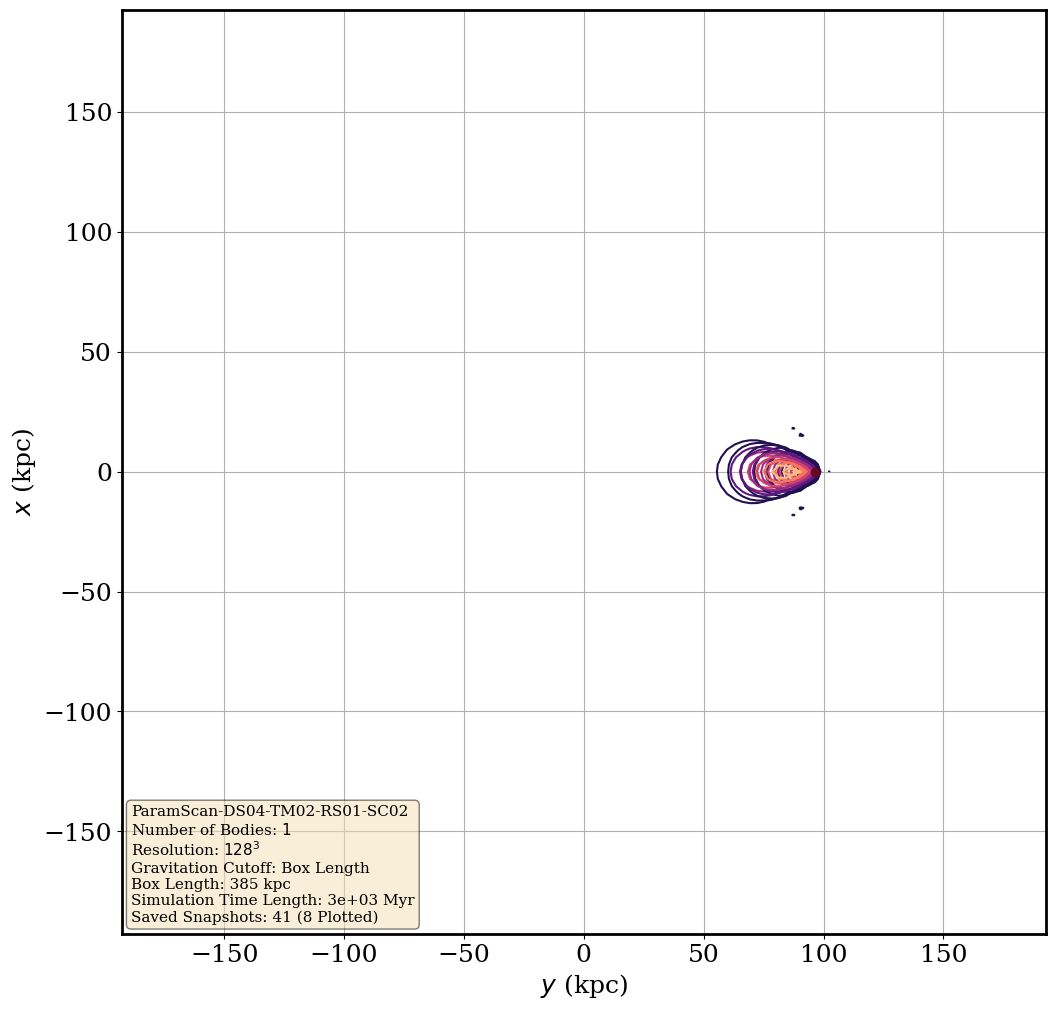

In [237]:
Plot_ULD = True
# Number of ULDM Slices IN BETWEEN start and end (which are always plotted).
NSlices = EndNum//6
Zoom2D = 1

if NSlices >= EndNum:
    
    NSlices = EndNum

try:
    TSD = TimeStamp
except NameError:
    TimeStamp = 'Debug'

plt.clf()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

Boundary = lengthKpc/(2*Zoom2D)

plt.xlim([-Boundary,Boundary])
plt.ylim([-Boundary,Boundary])

ax.set_aspect('equal', adjustable='box')

for i in range(EndNum):
    
    TMStateLoc = TMDataS[i,:]

    
    if i == 0:
        for particleID in range(len(particles)):

            Color = Colors[np.mod(particleID,5)] # 0, 0.5
        
            TMx = TMStateLoc[int(6*particleID+1)]
            TMy = TMStateLoc[int(6*particleID)]
            plt.plot([TMx],[TMy],'o',color=(0.5*Color[0],0.5*Color[1],0.5*Color[2],1))
        
    
    Alpha = 0.1+9*i/(10*EndNum)
    
    for particleID in range(len(particles)):
        

        Color = Colors[np.mod(particleID,5)] # 0, 0.5
  
        TMx = TMStateLoc[int(6*particleID+1)]
        TMy = TMStateLoc[int(6*particleID)]
        plt.scatter([TMx],[TMy],color=(Color[0],Color[1],Color[2],Alpha))
        
if Plot_ULD:
    
    planemax = np.max(data)
    planemin = np.min(data)

    levels = np.linspace(planemin, planemax, int(resol/16))

    PlotRange = np.linspace(-lengthKpc/2, lengthKpc/2,resol,endpoint = False)
    
    plt.contour(PlotRange,PlotRange,data[1], levels=levels,cmap = Palette)
    plt.contour(PlotRange,PlotRange,data[EndNum-1], levels=levels,cmap = Palette)


    if NSlices != 0 and EndNum >= NSlices:

        Blink = EndNum/(NSlices+1)

        Index = np.linspace(Blink,EndNum-Blink,NSlices)

        for Ind in Index:
            j = int(Ind)
            plt.contour(PlotRange,PlotRange,data[j], levels=levels,cmap = Palette)

        
ax.grid(True)

if B == 0:
    BDisp = 'Box Length'
else:
    BDisp = f'{B:3f} Box Length'

Info = '\n'.join((
    TimeStamp,
    r'Number of Bodies: $%.0f$' % (NBo, ),
    r'Resolution: $%.0f^3$' % (resol, ),
    r'Gravitation Cutoff: %s' % (BDisp),
    r'Box Length: %.3g kpc' % (lengthKpc, ),
    r'Simulation Time Length: %.3g Myr' % (durationMyr, ),
    r'Saved Snapshots: %.0f (%.0f Plotted)' % (EndNum,NSlices + 2)
    ))



# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in bottom left in axes coords
ax.text(0.01, 0.01, Info, transform=ax.transAxes, fontsize=11,
        verticalalignment='bottom', bbox=props)

if Zoom2D != 1:
    
    props2 = dict(boxstyle='round', facecolor='lightgreen', alpha=0.5)

    Zinfo = f"Zoom Level: {Zoom2D}x"
    ax.text(0.82, 0.95, Zinfo, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', bbox=props2)
    
ax.set_ylabel('$x$ (kpc)')
ax.set_xlabel('$y$ (kpc)')

TrajName = '{}{}{}{}{}'.format("./",save_path,"/_",TimeStamp,'.jpg')
plt.savefig(TrajName, format='jpg', dpi=72)

plt.show()

## Energy

Reconstructing Potential and Kinetic Energies for 1 stored objects.
ParamScan-DS04-TM02-RS01-SC02
Number of Bodies: $1$


<Figure size 640x480 with 0 Axes>

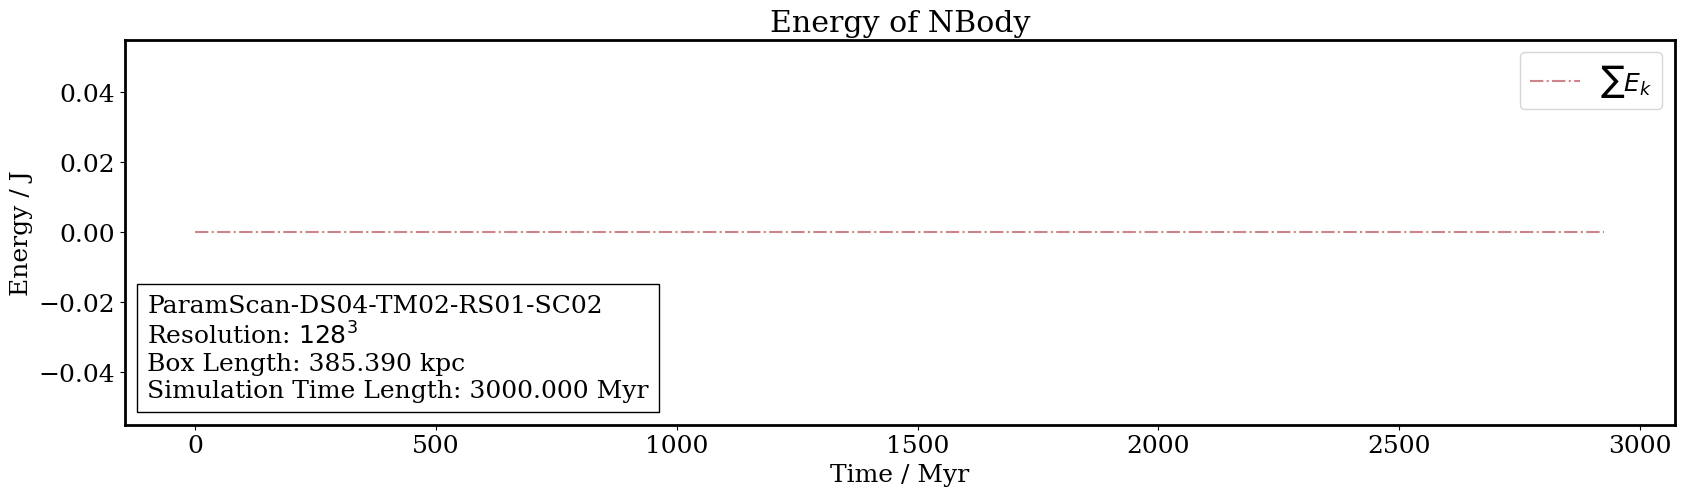

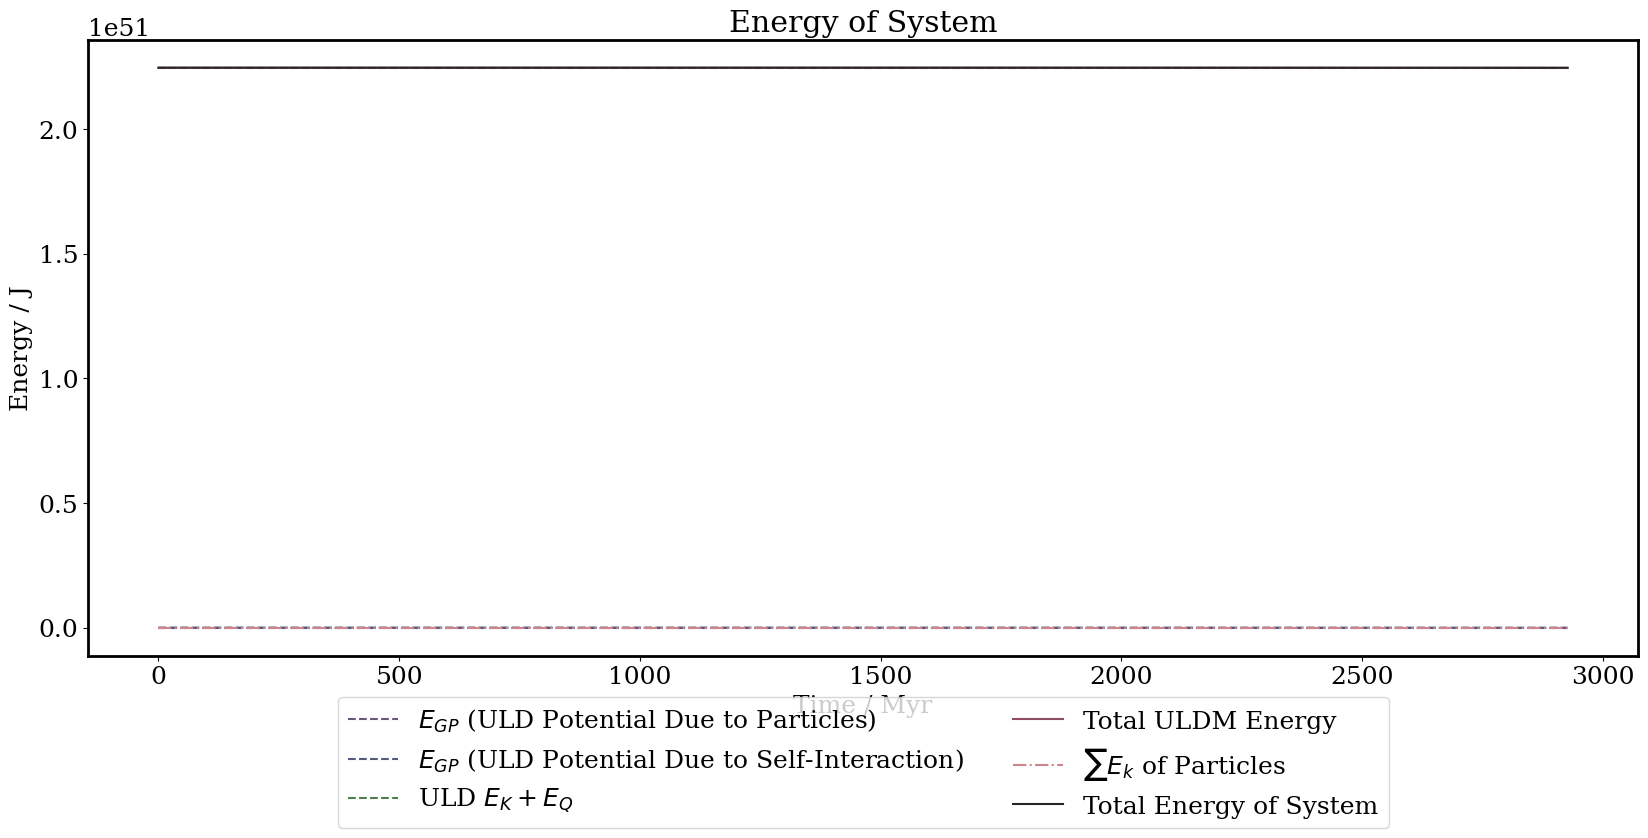

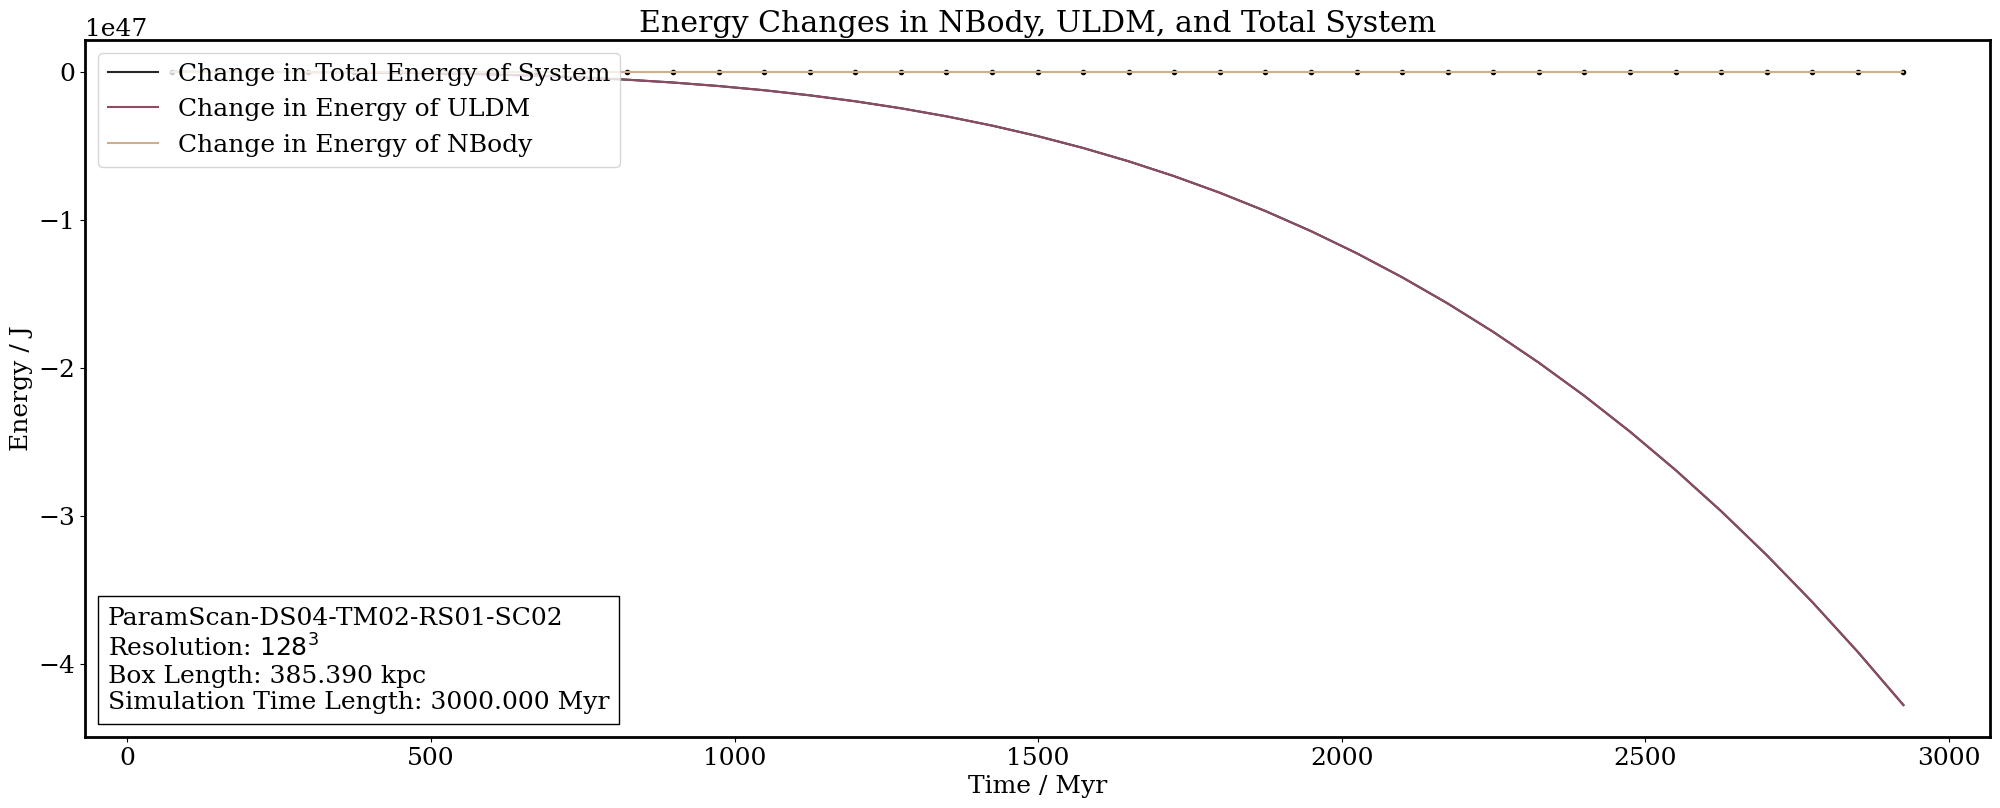

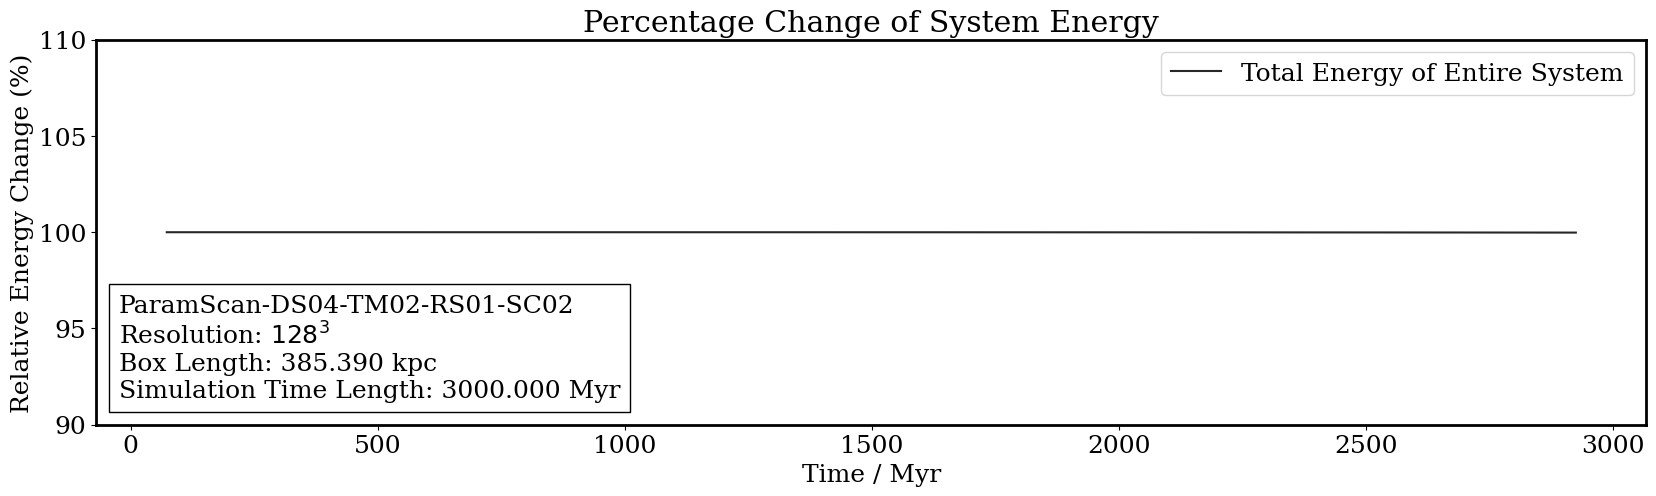

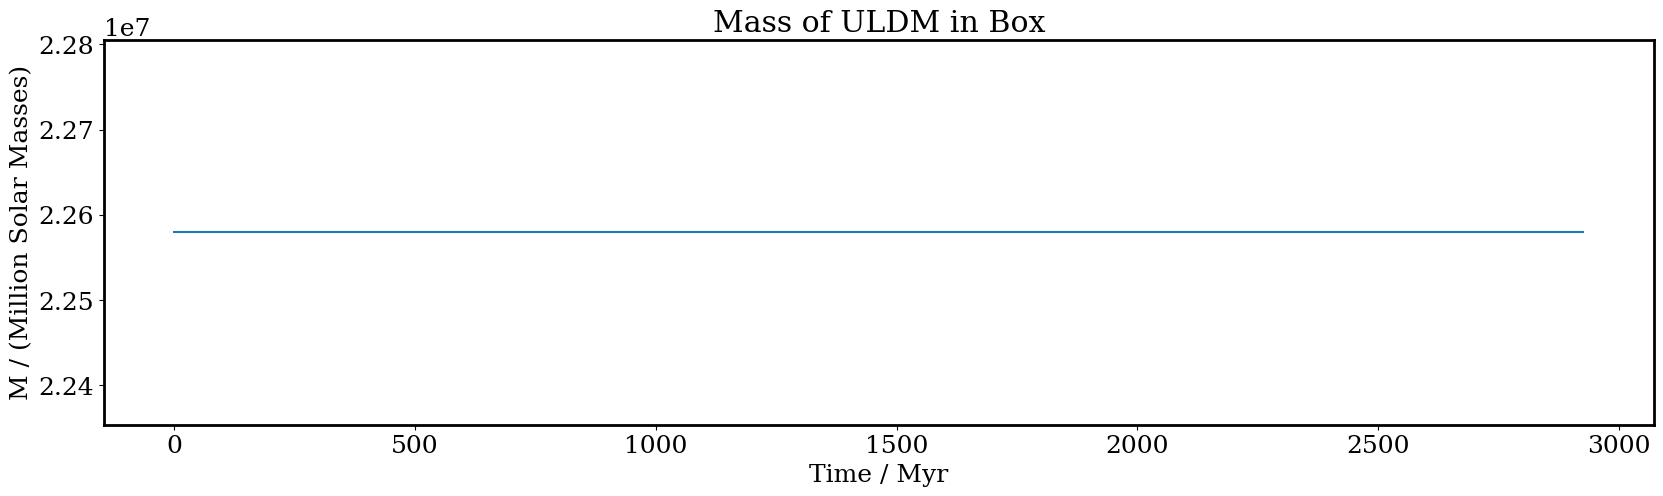

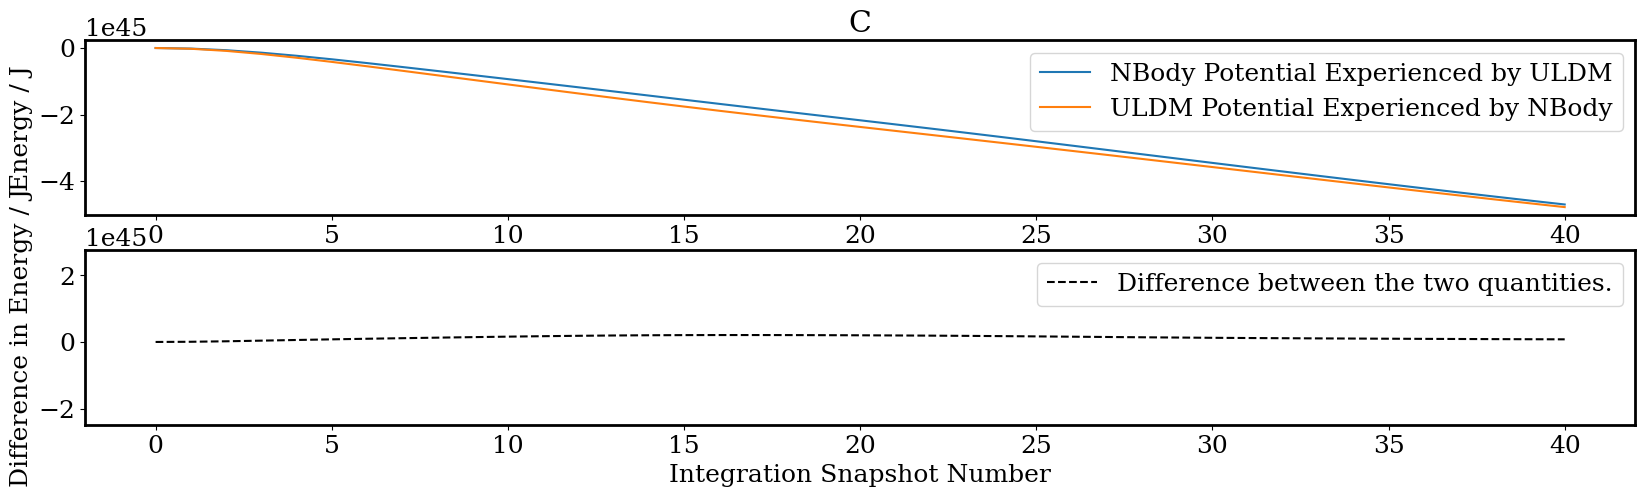

[[10, [0, 96.34761431758149, 0], [0, 0, 0]]]


In [238]:
EFigSize = (20,8)
EFigSize_Mono = (20,5)

Snap = False
loc = save_path + '/' + TimeStamp

plt.clf()

#==================================================================================================
## Naming
EnergyName = '{}{}{}'.format("./",loc,"/Energy_Total.jpg")
EnergyDName = '{}{}{}'.format("./",loc,"/Energy_Delta.jpg")
EnergyMName = '{}{}{}'.format("./",loc,"/Energy_Mech.jpg")
EnergyD2Name = '{}{}{}'.format("./",loc,"/Energy_Pct.jpg")

#==================================================================================================
## Analysis
#
# Load ULDM Energy

egylist2 = np.load('{}{}'.format(loc, '/Outputs/egylist.npy'),allow_pickle=True) * EPre
egpcmlist2 = np.load('{}{}'.format(loc, '/Outputs/egpcmlist.npy'),allow_pickle=True) * EPre
egpcmlist = np.load('{}{}'.format(loc, '/Outputs/egpcmMlist.npy'),allow_pickle=True) * EPre # Using Interpolation
egpsilist = np.load('{}{}'.format(loc, '/Outputs/egpsilist.npy'),allow_pickle=True) * EPre
ekandqlist = np.load('{}{}'.format(loc, '/Outputs/ekandqlist.npy'),allow_pickle=True) * EPre
mtotlist = np.load('{}{}'.format(loc, '/Outputs/masseslist.npy'),allow_pickle=True) * EPre

# Uniform Correction Performed in Integrator!

# Reconstruct NBody Energy (Real)
#NBo, KS, PS = PyUL.NBodyEnergy(MassListSI,TMDataSI,EndNum, a, length_units)

# Reconstruct NBody Energy (Physical)
NBo, KS, PS = PyUL.NBodyEnergy(MassListSI,TMDataSI,EndNum)

# Translating Snapshots back to Time
timerange = np.linspace(0,durationMyr,save_number+1)

Tp = np.linspace(0,EndNum-1,EndNum)
Tp = Tp * durationMyr / (save_number+1)

Tpt = np.linspace(1,EndNum,EndNum-2,endpoint = False) 
Tpt = Tpt/(save_number+1) * durationMyr

KSD = KS - KS[1]
PSD = PS - PS[1]

egylist = egpcmlist + egpsilist + ekandqlist

egylistD = egylist - egylist[1]
TotalED = PSD+KSD+egylistD

MES = PS + KS

MESD = PSD + KSD

MESGrad = np.sum(MESD)/np.sum(Tp)

TotalER = (KS + PS + egylist) / (KS[1]+PS[1]+egylist[1])*100

ULDER =  egylist/ egylist[1]


#==================================================================================================
## Compile Printing Boxes

SimInfo = '\n'.join((
    TimeStamp,
    r'Resolution: $%.0f^3$' % (resol, ),
    r'Box Length: %.3f kpc' % (lengthKpc, ),
    r'Simulation Time Length: %.3f Myr' % (durationMyr, )
    ))

NBodyInfo = '\n'.join((
    TimeStamp,
    r'Number of Bodies: $%.0f$' % (NBo, ),
    ))

print(NBodyInfo)

#==================================================================================================
## Plots
# NBody Energy Diagram
fig = plt.figure(figsize= EFigSize_Mono)
ax = fig.add_subplot(111)
InfoBox = AnchoredText(SimInfo, loc=3)
ax.add_artist(InfoBox)

plt.plot(Tp,KS,ENStyle,color = EKColor,label = '$\sum E_k$')
#plt.ylim(0,)
if len(particles) >= 2:
    plt.plot(Tp,PS,ENStyle,color = EPColor,label = '$\sum E_p$')
    plt.plot(Tp,PS+KS,ETStyle,color = ENColor, label = '$E_k + E_p$')
#plt.plot(Tp,0*Tp,'k--')

plt.title('Energy of NBody')
plt.xlabel('Time / Myr')
plt.ylabel('Energy / J')

plt.legend()

plt.show()

#==================================================================================================
# System Energy Diagram
fig = plt.figure(figsize= EFigSize)
ax = fig.add_subplot(111)

plt.plot(Tp,egpcmlist,EUStyle,color = EGColor,label='$E_{GP}$ (ULD Potential Due to Particles)')
plt.plot(Tp,egpsilist,EUStyle,color = ERColor,label='$E_{GP}$ (ULD Potential Due to Self-Interaction)')
plt.plot(Tp,ekandqlist,EUStyle,color = EQColor,label='ULD $E_{K}+E_{Q}$')

plt.plot(Tp,egylist,ETStyle,color = EUColor,label='Total ULDM Energy')

plt.plot(Tp,KS,ENStyle,color = EKColor,label = '$\sum E_k$ of Particles')

if len(particles) >= 2:
    plt.plot(Tp,PS,ENStyle,color = EPColor,label = '$\sum E_p$ of Particles')
    plt.plot(Tp,PS+KS,ETStyle,color = ENColor,label = 'Total Mechanical Energy of Particles')


plt.plot(Tp,PS+KS+egylist,ETStyle,color = ETColor, label = 'Total Energy of System')
plt.legend(ncol=2,bbox_to_anchor=(0.5, -0.3),loc='lower center')

plt.xlabel('Time / Myr')
plt.ylabel('Energy / J')

plt.title('Energy of System')
plt.savefig(EnergyName, format='jpg', dpi=72)

plt.show()

#==================================================================================================
# The Advanced Energy Change Diagram
fig = plt.figure(figsize= EFigSize)
ax = fig.add_subplot(111)
InfoBox = AnchoredText(SimInfo, loc=3)
ax.add_artist(InfoBox)

plt.plot(Tpt,TotalED[1:-1],ETStyle,color = ETColor, label = 'Change in Total Energy of System')
plt.plot(Tpt,0*Tpt,HelperStyle, label = '')
plt.plot(Tpt,egylistD[1:-1],ETStyle,color = EUColor, label = 'Change in Energy of ULDM')
plt.plot(Tpt,KSD[1:-1]+PSD[1:-1],ETStyle,color = ENColor, label = 'Change in Energy of NBody')

plt.legend(loc = 'upper left',frameon = True)

plt.xlabel('Time / Myr')
plt.ylabel('Energy / J')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# plt.ylim([98,102])
plt.title('Energy Changes in NBody, ULDM, and Total System')
plt.savefig(EnergyDName, format='jpg', dpi=72)

plt.show()

#==================================================================================================
# The Advanced Energy Change Ratio Diagram
fig = plt.figure(figsize= EFigSize_Mono)
ax = fig.add_subplot(111)
InfoBoxD = AnchoredText(SimInfo, loc=3)
ax.add_artist(InfoBoxD)


ax.plot(Tpt,TotalER[1:-1],ETStyle, color = ETColor, label = 'Total Energy of Entire System')
ax.set_xlabel('Time / Myr')
ax.legend()

ax.set_ylabel('Relative Energy Change (%)')
ax.set_ylim([90.0,110.0])
ax.set_title('Percentage Change of System Energy')

plt.savefig(EnergyD2Name, format='jpg', dpi=72)

plt.show()


#==================================================================================================
# The Net Mass Diagram

MassData = np.load('{}{}'.format(loc, '/Outputs/ULDMass.npy'),allow_pickle=True)

MDataMSol = ToPhys(MassData,'M_solar_masses','m')

fig = plt.figure(figsize= EFigSize_Mono)
ax = fig.add_subplot(111)

ax.plot(Tp,MDataMSol)
ax.set_xlabel('Time / Myr')
ax.set_ylim([0.99*np.min(MDataMSol),1.01*np.max(MDataMSol)])

ax.set_ylabel('M / (Million Solar Masses)')
ax.set_title('Mass of ULDM in Box')
plt.show()

#==================================================================================================
# Redundancy Check

fig = plt.figure(figsize = EFigSize_Mono)
ax = fig.add_subplot(211)

ax.plot(egpcmlist2,label = 'NBody Potential Experienced by ULDM')
ax.plot(egpcmlist,label = 'ULDM Potential Experienced by NBody')

ax.legend()

plt.ylabel('Energy / J')

ax.set_title('C')

#==================================================================================================
# Redundancy Check 2

axR = fig.add_subplot(212)

GDiff = egpcmlist2 - egpcmlist

axR.plot(GDiff,'k--',label= 'Difference between the two quantities.')
axR.legend()
axR.set_xlabel('Integration Snapshot Number')
plt.ylabel('Difference in Energy / J')

GLower = ax.get_ylim()[0]
GUpper = ax.get_ylim()[1]

G2 = (GUpper - GLower)/2

GMean = np.mean(GDiff)

axR.set_ylim(GMean - G2, GMean + G2)

plt.show()


print(particles)

In [ ]:
#==================================================================================================
# Redundancy Check 3

#fig = plt.figure(figsize = EFigSize_Mono)

#ax = fig.add_subplot(111)

#ax.plot(egpcmlist2,label = 'NBody Potential Experienced by ULDM')
#ax.plot(Tp,egpcmlist2,label = '$M\Phi_U$')

#ax.plot(Tp,-KS,label = '$-E_K$')


#EZ = np.zeros(EndNum)

#ax.plot(Tp,-EZ-1/2*MassListSI[0]*(CB(speed,s_velocity_unit,'m/s','v'))**2,'--',label = '$-E_{k0}$')

#ax.legend()
#ax.grid()

#ax.set_ylabel('Energy / J')
#ax.set_xlabel('Time / Myr')
#plt.show()


## [Dynamical Friction Workbench 2]


This section is for Use with ** Dynamical Friction ** presets only.

### Base

In [239]:
Tp = np.linspace(0,EndNum-1,EndNum)
Tp = Tp * durationMyr / (save_number+1)

Tpt = np.linspace(1,EndNum,EndNum-2,endpoint = False) 
Tpt = Tpt/(save_number+1) * durationMyr

vRel0 = -CB(UVel[1],s_velocity_unit,'m/s','v') + TMDataSI[:,4]

mBH = MassList_MSol[0] # Million MSols
mBH_kg = CB(mBH,'M_solar_masses','kg','m')


lR = PyUL.hbar/(PyUL.axion_mass*vRel0) # Has a factor of 2pi removed.

lRP = PyUL.convert_between(lR,'m','pc','l')

# Quantum Mach Number

MQ = 44.56*vRel0/1000*(((1e-22*PyUL.eV))/PyUL.axion_mass)/mBH/10

beta = 2*np.pi*PyUL.G*mBH_kg/(vRel0[0])**2/(lR[0])

# Reference Force Value

FRel = 4*np.pi*Density*DPre*(PyUL.G*mBH*1e6*PyUL.solar_mass/(vRel0))**2

### b

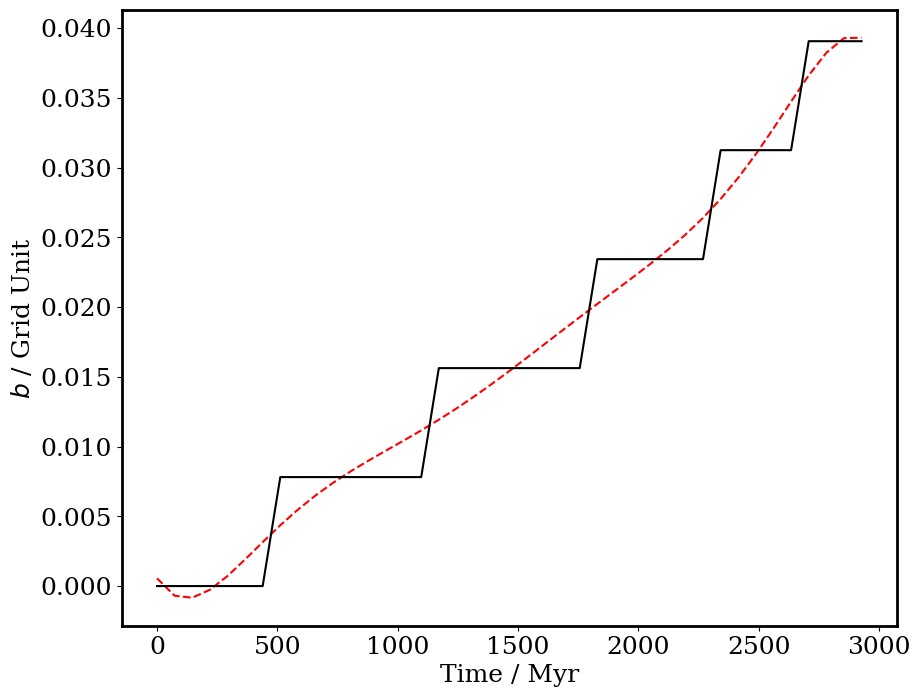

In [240]:
SFC = PyUL.SliceFinderC

def ySlice(i):
    
    RPt = SFC(TMdata[i],resol,lengthC,verbose = False)
    
    return RPt[1]

bProto = np.zeros(EndNum)

plt.figure(figsize = (10,8))

for i in range(EndNum):
    
    if i==0:
        bProto[i] = 0
    
    else:
        LP = np.array(data[i][resol//2,:])
        
        #print((np.where(LP == np.max(LP)))[0], ySlice(i))
        bProto[i] = (ySlice(i) - (np.where(LP == np.max(LP)))[0])/resol
        
# plt.plot(Tp,bProto)

Fit = np.polyfit(Tp,bProto,8)

bFit = np.polyval(Fit,Tp)

# bFit = bProto

plt.xlabel('Time / Myr')
plt.ylabel("$b$ / Grid Unit")

BCut = length*bFit # maximum simulated distance is the domain's volume diagonal
    
BCutTilde = CB(BCut,length_units,'pc','l')/lRP

Lambda = BCutTilde/beta

# Expected DynDrag

CLambda = np.log(2*Lambda) + 1/Lambda*np.log(2*Lambda) - 1

bProtoEb = 0.25*np.ones(EndNum)/resol

plt.errorbar(Tp,bProto,0, color = 'k')
plt.plot(Tp,bFit,'r--')

BCutMax = length*(bFit+bProtoEb)
    
BCutTildeMax = CB(BCutMax,length_units,'pc','l')/lRP

BCutMin = length*(bFit-bProtoEb)
    
BCutTildeMin = CB(BCutMin,length_units,'pc','l')/lRP

### C

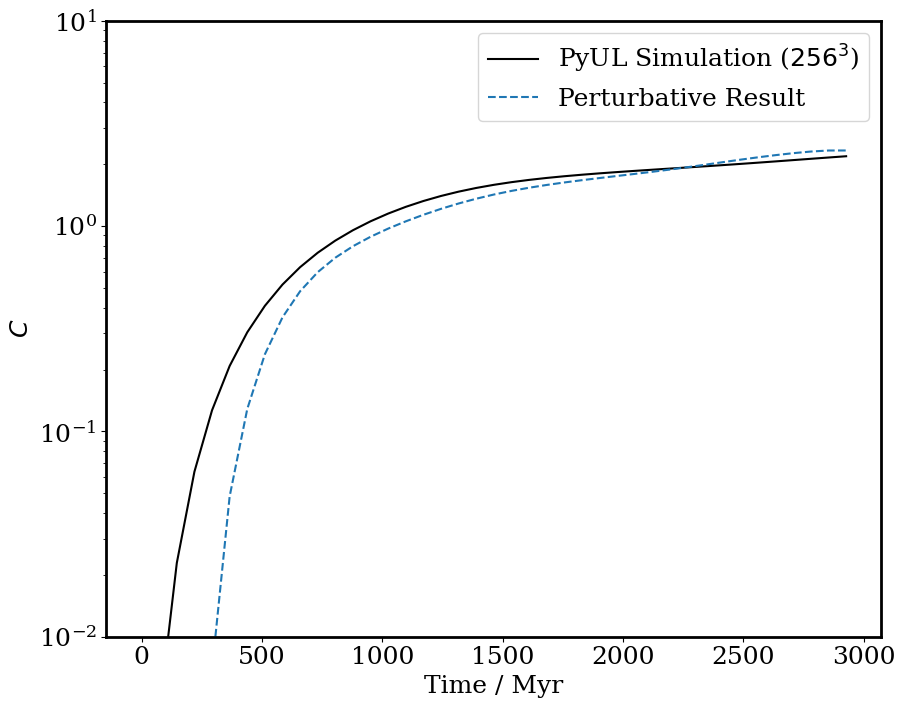

In [241]:
# Gravitational Attraction of DM Wake
CLogDF2 = -1*np.array(graddata)[:,1] * PyUL.length_unit/PyUL.time_unit**2 # 1 Code Acceleration Unit

# Phi is already in m/s^2 

Crel = CLogDF2*vRel0**2/(4*np.pi*PyUL.convert_back(Density,'kg/m3','d')*PyUL.G**2*mBH_kg)

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)

ax.semilogy(Tp,Crel,'k',label = 'PyUL Simulation ($256^3$)')
ax.set_xlabel('Time / Myr')
ax.set_ylabel("$C$")

# Exact Evaluation

from scipy.special import sici as SiCin

Sb2,Cb2 = SiCin(2*BCutTilde)

RealCb2 = np.euler_gamma + np.log(2*BCutTilde) - Cb2

CrelAna = RealCb2+np.sin(2*BCutTilde)/(2*BCutTilde)-1

ax.plot(Tp,CrelAna,'--',label = 'Perturbative Result')

ax.legend()

ax.set_ylim(0.01,10)

plt.show()

CrelMax = np.max(Crel)

In [ ]:
for i in range(EndNum):
    plt.plot(PlotRange,data[i][resol//2,:]-Density)

### Main Framework

Initial Relative Speed: 10000.0000 m/s
BH Mass: 10.0000 Mil. MSol.
λ = 12.0435 kpc
M = 1.989e+37 kg
β = 0.224303
Reference Force: 5.9063e+24 N


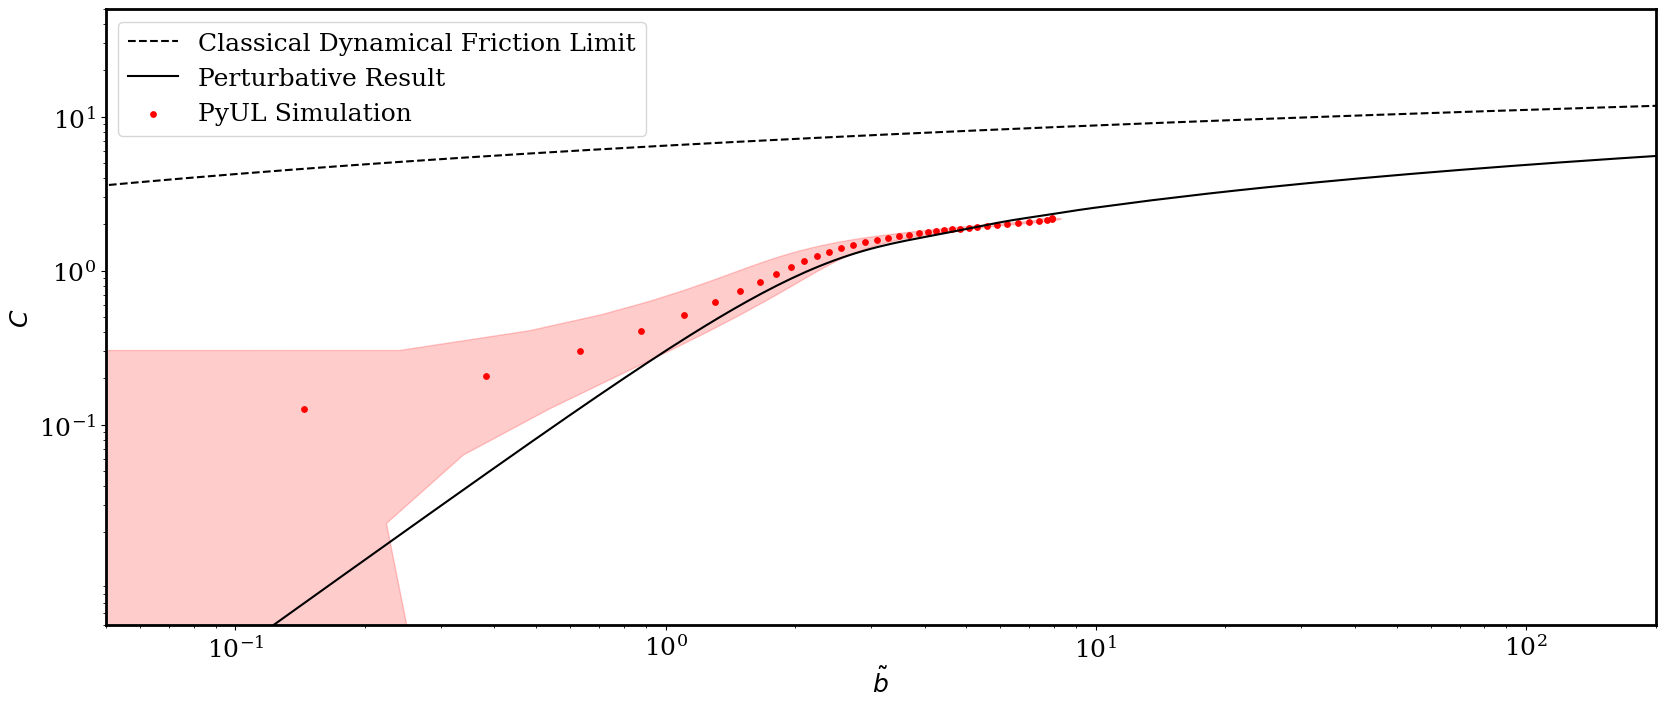

In [242]:
plt.figure(figsize = (20,8))

BLine = np.linspace(-2,3,300)

BLineX = 10**BLine

rSys = PyUL.convert_between(length*BLineX,length_units,'m','l')

Lambda = vRel0[0]**2*rSys/(PyUL.G*mBH_kg)

# Classical B

C_Cl = np.log(2*Lambda) - 1 + 1/Lambda*np.log(2*Lambda)

F_Cl = 4*np.pi*PyUL.G**2*mBH_kg**2*Density*PyUL.convert_back(1,'kg/m3','d')/(vRel0[0]**2)*C_Cl / FRel[0]

# Classical A

C_A = (1+Lambda)/(Lambda)*np.arctanh(np.sqrt(Lambda**2+2*Lambda)/(1+Lambda)) - np.sqrt(1+2/Lambda)


plt.loglog(BLineX,C_A,'k--',label = 'Classical Dynamical Friction Limit')

#plt.loglog(BLineX,C_Cl,'--',label = 'Classical Dynamical Friction Limit B')

from scipy.special import sici as SiCin

Sb,Cb = SiCin(2*BLineX)

RealCb = np.euler_gamma + np.log(2*BLineX) - Cb

plt.loglog(BLineX,RealCb+np.sin(2*BLineX)/(2*BLineX)-1,'k', label = 'Perturbative Result')

#plt.loglog(BLineX,1/3*BLineX**2,color = 'green',label = 'Lancaster Low b Asymptote')

from scipy.special import digamma as Dig

beta = PyUL.G*mBH_kg/(vRel0[0]**2*lR[0])

#plt.loglog(BLineX,np.log(2*BLineX)-1-np.real(Dig(1+1j*beta)),color = 'orange',label = 'Lancaster High b Asymptote')


# Final A is already in m/s^2 
FinalA = CLogDF2


Crel = FinalA*vRel0**2/(4*np.pi*PyUL.convert_back(Density,'kg/m3','d')*PyUL.G**2*mBH_kg)

plt.scatter(BCutTilde,Crel,label = 'PyUL Simulation' ,  color = 'r', s = 15          )

plt.fill_betweenx(Crel,BCutTildeMin, BCutTildeMax,  color = 'r', alpha = 0.2)


plt.xticks([0.1,1,10,100,1000])
plt.yticks([0.1,1,10])

plt.xlabel('$\~{b} $')
plt.ylabel('$C$ ')

plt.ylim(0.005,50)

plt.xlim(0.05,200)

plt.legend()

print(f'Initial Relative Speed: {vRel0[0]:.4f} m/s\n\
BH Mass: {mBH:.4f} Mil. MSol.')

print(f"λ = {2*np.pi*lRP[0]/1000:.6g} kpc")

print(f"M = {mBH_kg:.6g} kg")

print(f"β = {beta:.6g}")

print(f'Reference Force: {FRel[0]:.5g} N')

In [ ]:
plt.scatter(BCutTilde,Crel,label = 'PyULN Simulation',
             color = 'r', marker = '.')

In [ ]:
9427.315877085271*2

## 2D Complex Field

In [ ]:
try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

    
Loga = False 

DensityGR = Density

loc = save_path + '/' + TimeStamp

AnimName = '{}{}{}{}'.format(loc,"/AnimComplex_",VTimeStamp,".mp4")


if Loga:

    data0 = np.log(np.array(data)/DensityGR)
    planemax = np.max(data0)
    planemin = np.min(data0)
    TITLETEXT = 'Logarithmic Overdensity and Phase'
    
else:

    data0 = np.array(data)/DensityGR
    planemax = np.max(data0)
    planemin = np.min(data0)
    TITLETEXT = 'Overdensity and Phase'

TITLETEXT = VTimeStamp + ': ' + TITLETEXT

print("Saving ",AnimName)

plot_axis = 'z' #axis that is set to zero
plt.ioff()
fig0, ax0 = plt.subplots(figsize=(16, 9), dpi=144)
ax0.set_aspect('equal')

PlotRange = np.linspace(-lengthKpc/2, lengthKpc/2,resol,endpoint = False)

# print(PlotRange)

FPS = 5

levels = np.linspace(planemin, planemax, int(resol/4))

def animate3(i):
    
    ts = time.time()
    ax0.cla()
    ax0.set_aspect('equal')
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([])
    
    
    Plane = np.real(phasedata[i])
    
    ax0.imshow(Plane,cmap = CycPalette,origin = 'lower',
               vmin = -np.pi, vmax = np.pi,
               extent = (-lengthKpc/2,lengthKpc/2,-lengthKpc/2,lengthKpc/2),
              interpolation = 'none')
    
    TMStateLoc = TMDataS[i,:]
    
    for particleID in range(len(particles)):
        

        Color = Colors[np.mod(particleID,5)] # 0, 0.5
        
        TMx = TMStateLoc[int(6*particleID+1)]
        TMy = TMStateLoc[int(6*particleID)]
        TMz = TMStateLoc[int(6*particleID+2)]
        
        Vx = TMStateLoc[int(6*particleID+4)]
        Vy = TMStateLoc[int(6*particleID+3)]
        Vz = TMStateLoc[int(6*particleID+5)]
        ax0.plot([TMx],[TMy],'o',color=(Color[0],Color[1],Color[2],1))
        #ax0.quiver([TMx],[TMy],[Vx],[Vy])
        
    ax0.contour(PlotRange,PlotRange,data0[i], levels=levels,cmap = Palette)
    ax0.text(0.5, 1.05, '{}{:.4f}{}'.format('Time Elapsed: ', Tp[i],' Million Years'),
             horizontalalignment='center', verticalalignment='center', 
             transform=ax0.transAxes,color = 'black')
    fig0.suptitle('{} {}{}'.format(TITLETEXT, plot_axis, '=0'), fontsize = 12)
    PyUL.prog_bar(EndNum, i+1, time.time()-ts)
    
    if i == EndNum-1:
        print('\nAnimation Complete')

interval = 0.15 #in seconds
ani3 = matplotlib.animation.FuncAnimation(fig0,animate3,EndNum,interval=interval*1e+3,blit=False)



Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))



ani3.save(AnimName, writer=writer)


'''
from IPython.display import HTML
animated_plot3 = HTML(ani3.to_jshtml())

display(animated_plot3) 
'''



In [ ]:
fig0, ax0 = plt.subplots(figsize=(16, 9), dpi=144)
ax0.set_aspect('equal')
animate3(33)

plt.show()

## 2D Field Argument

In [ ]:
try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

loc = save_path + '/' + TimeStamp

AnimName = '{}{}{}{}'.format(loc,"/AnimPhase_",VTimeStamp,".mp4")

print("Saving ",AnimName)

plot_axis = 'z' #axis that is set to zero
plt.ioff()
fig0, ax0 = plt.subplots(figsize=(16, 16), dpi=72)
ax0.set_aspect('equal')

PlotRange = np.linspace(-lengthKpc/2, lengthKpc/2,resol,endpoint = False)

# print(PlotRange)

FPS = 5


def animate3(i):
    
    ts = time.time()
    ax0.cla()

    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([])
    
    
    Plane = np.real(phasedata[i])
    
    ax0.imshow(Plane,cmap = CycPalette,origin = 'lower',
               vmin = -np.pi, vmax = np.pi,
               extent = (-lengthKpc/2,lengthKpc/2,-lengthKpc/2,lengthKpc/2),
              interpolation = 'none')
    
    TMStateLoc = TMDataS[i,:]
    
    for particleID in range(len(particles)):
        
        Color = Colors[np.mod(particleID,5)] # 0, 0.5
        
        TMx = TMStateLoc[int(6*particleID+1)]
        TMy = TMStateLoc[int(6*particleID)]
        TMz = TMStateLoc[int(6*particleID+2)]
        
        Vx = TMStateLoc[int(6*particleID+4)]
        Vy = TMStateLoc[int(6*particleID+3)]
        Vz = TMStateLoc[int(6*particleID+5)]
        ax0.plot([TMx],[TMy],'o',color=(Color[0],Color[1],Color[2],1))
        ax0.quiver([TMx],[TMy],[Vx],[Vy])
  
    PyUL.prog_bar(EndNum, i+1, time.time()-ts)
    
    if i == EndNum-1:
        print('\nAnimation Complete')

interval = 0.15 #in seconds
ani3 = matplotlib.animation.FuncAnimation(fig0,animate3,EndNum,interval=interval*1e+3,blit=False)



Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

ani3.save(AnimName, writer=writer)



from IPython.display import HTML
animated_plot3 = HTML(ani3.to_jshtml())

fig0.clear()
display(animated_plot3) 


## [1D Mass Density]

In [ ]:
try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

AnimName = '{}{}{}{}'.format(loc,"/AnimLineDensity_",VTimeStamp,".mp4")

figD = plt.figure(figsize = (16,9))
axD = figD.add_subplot(111)

PlotRange = np.linspace(-lengthKpc/2, lengthKpc/2,resol,endpoint = False)

def animateD(i):
    
    ts = time.time()
    axD.cla()

    axD.set_xlabel('X (kpc)')
    axD.set_ylabel('Y (kpc)')

    axD.plot(PlotRange,data[i][int(resol/2),:]/Density-1)
    axD.scatter(TMDataS[i,1],[0])

    plt.ylabel('Density')
    plt.xlabel('Position (kpc)')
     
    PyUL.prog_bar(EndNum, i+1, time.time()-ts)
    if i == EndNum-1:
        print('\nAnimation Complete')
    
    
interval = 0.001 #in seconds
aniD = matplotlib.animation.FuncAnimation(figD,animateD,EndNum,interval=interval*1e+3,blit=False)


Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

aniD.save(AnimName, writer=writer)

from IPython.display import HTML
animated_plotD = HTML(aniD.to_jshtml())

figD.clear()
display(animated_plotD) 

## 2D Mass Density

In [ ]:
Loga = True
Contour = False

try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

AnimName = '{}{}{}{}'.format(loc,"/AnimDensity_",VTimeStamp,".mp4")

print("Saving ",AnimName)

plot_axis = 'z' #axis that is set to zero
plt.ioff()
fig0, ax0 = plt.subplots(figsize=(16, 9), dpi=100)
ax0.set_aspect('equal')

Tp = np.linspace(0,EndNum-1,EndNum)
Tp = Tp * durationMyr / (save_number+1)

DensityGR = Density

if Loga:
    
    if Uniform:
        data0 = np.log(np.array(data)/DensityGR)
        print("Initial Field is Uniform. Evaluating Change Ratio.")
        planemax = np.max(data0)
        planemin = np.min(data0)
        TITLETEXT = 'Logarithmic Over (Under) density in Plane'

    else:
        data0 = np.log(data)
        planemax = np.max(data0)
        planemin = -1
        TITLETEXT = 'Logarithmic Mass Density in Plane'
    
    print("Using Log Plot, the Contour Level Limits Are")
    
    
else:
    if Uniform:
        data0 = np.array(data)/DensityGR
        print("Initial Field is Uniform. Evaluating Change Ratio.")
        planemax = np.max(data0)
        planemin = np.min(data0)
        TITLETEXT = 'Over (Under) Density in Plane'

    else:
        data0 = (data)
        planemax = np.max(data0)
        planemin = np.min(data0)
        TITLETEXT = 'Mass Density in Plane'
        
TITLETEXT = VTimeStamp + ': ' + TITLETEXT

levels = np.linspace(planemin, planemax, int(resol/4))

print(f"Max:{planemax},Min:{planemin}")

PlotRange = np.linspace(-lengthKpc/2, lengthKpc/2,resol,endpoint = False)

# print(PlotRange)



def animate0(i):
    
    ts = time.time()
    ax0.cla()
    ax0.set_aspect('equal')
    ax0.set_xlim([-lengthKpc/2,lengthKpc/2])
    ax0.set_ylim([-lengthKpc/2,lengthKpc/2])

    ax0.set_xlabel('X (kpc)')
    ax0.set_ylabel('Y (kpc)')
    
    if Contour:
        mappable = ax0.contour(PlotRange,PlotRange,data0[i], levels=levels,cmap = Palette)
    
    else:
        mappable = ax0.imshow(data0[i],cmap = Palette,origin = 'lower',
                  vmin = planemin, vmax = planemax, interpolation = 'bicubic',
                   extent = (-lengthKpc/2,lengthKpc/2,-lengthKpc/2,lengthKpc/2))
    

    TMStateLoc = TMDataS[i,:]
    
    for particleID in range(len(particles)):
        
        if particles[particleID][0] <= 1e-2:
            Color = np.ones(3)
            size = 1
        else:
            Color = Colors[np.mod(particleID,5)] # 0, 0.5
            size = 3
        
        TMx = TMStateLoc[int(6*particleID+1)]
        TMy = TMStateLoc[int(6*particleID+0)]
        TMz = TMStateLoc[int(6*particleID+2)]
        
        Vx = TMStateLoc[int(6*particleID+4)]
        Vy = TMStateLoc[int(6*particleID+3)]
        Vz = TMStateLoc[int(6*particleID+5)]
        
        ax0.scatter([TMx],[TMy],s = size, color=(Color[0],Color[1],Color[2],1),)
        ax0.quiver([TMx],[TMy],[Vx],[Vy],color=(0.5+0.5*Color[0],0.5+0.5*Color[1],0.5+0.5*Color[2],0.7))
        
    fig0.suptitle('{} {}{}'.format(TITLETEXT, plot_axis, '=0'), fontsize = 15)
    ax0.text(0.5, 1.05, '{}{:.4f}{}'.format('Time Elapsed: ', Tp[i],' Million Years'), horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes,color = 'orange')
 
    PyUL.prog_bar(EndNum, i+1, time.time()-ts)
    if i == EndNum-1:
        print('\nAnimation Complete')

interval = 0.001 #in seconds
ani0 = matplotlib.animation.FuncAnimation(fig0,animate0,EndNum,interval=interval*1e+3,blit=False)


Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

ani0.save(AnimName, writer=writer)


if EndNum <= 20:
    from IPython.display import HTML
    animated_plot0 = HTML(ani0.to_jshtml())

    fig0.clear()
    display(animated_plot0) 


## 2D Gravitational Field Slice

In [ ]:
NumSol = len(solitons)
try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

AnimName = '{}{}{}{}'.format(save_path,"/Anim3D_",VTimeStamp,'.mp4')

print("Saving ",AnimName)

# Initialization
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')

ax.view_init(90, 0)

PlotRange = np.linspace(-length/2, length/2,resol)

zoom = 0.8

FPS = 60 

x3D, y3D = np.meshgrid(PlotRange,PlotRange)

phidataP = np.array(phidata)*-1

planemax = np.max(phidataP)*1.2
planemin = np.min(phidataP)

print(planemin,planemax)

levels = np.linspace(planemin, planemax, 100)

def animate(i):
    fig.clear()
    global FPS
    
    TMStateLoc = TMdata[i]
    ax = fig.gca(projection='3d')

    ax.view_init(0, 0)

    ax.set_zlim3d(planemin, planemax)
    ax.set_ylim3d(-length/(2*zoom), length/(2*zoom))                    
    ax.set_xlim3d(-length/(2*zoom), length/(2*zoom))

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    if NumSol != 0:
        
        #ax.contour(PlotRange,PlotRange,(phidata[i]),zdir='z', offset=0, cmap=cm.coolwarm, levels = levels)
        

        zs = phidataP[i].flatten()
        ax.plot_wireframe(x3D,y3D,phidataP[i],rcount = resol, ccount = resol)
 
    
    for particleID in range(len(particles)):
        TMx = TMStateLoc[int(6*particleID)]
        TMy = TMStateLoc[int(6*particleID+1)]
        TMz = TMStateLoc[int(6*particleID+2)]
        
        Vx = TMStateLoc[int(6*particleID+3)]
        Vy = TMStateLoc[int(6*particleID+4)]
        Vz = TMStateLoc[int(6*particleID+5)]
        ax.plot([TMy],[TMx],[TMz],'ko')
        ax.quiver([TMy],[TMx],[TMz],[Vy],[Vx],[Vz],length=length/(resol*zoom), normalize=False)
    #ax.plot([TMS[i,0]],[TMS[i,1]],[TMS[i,2]],'ro')
    
        ax.text(TMy, TMx, TMz, '{}{}{}'.format(particleID,'Particle Snapshot # ', i))

    
    if i%FPS == 0 and i!= 0:
        print('Animated %.0f seconds out of %.2f seconds of data.' % (i/FPS, EndNum/FPS))
        
    if i == EndNum-1:
        print('Animation Complete')
        
    plt.draw() 

Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

interval = 0.05 #in seconds


ani = matplotlib.animation.FuncAnimation(fig,animate,EndNum,interval=interval*1e+3,blit=False)

ani.save(AnimName, writer=writer)
 

## 1D Gravitational Field Slice

In [ ]:
AnimName = '{}{}{}{}'.format(loc,"/AnimLineField_",TimeStamp,".mp4")

figD = plt.figure(figsize = (16,9))
axD = figD.add_subplot(111)

ADim = CB(a,'m','','l')

FPS = 5

GLow = np.min(phidata)* EPre / MassListSI[0]
GMax = np.max(phidata)* EPre / MassListSI[0]

PlotRange = np.linspace(-lengthKpc/2, lengthKpc/2,resol,endpoint = False)

def animatePG(i):
    
    ts = time.time()
    axD.cla()

    axD.set_xlabel('Y (kpc)')
    axD.set_ylabel('$\phi$')
    #for j in range(resol):
    #    axD.scatter(PlotRange,phidata[i][j,:],s = 1, color = 'black')
    axD.scatter(PlotRange,phidata[i][resol//2,:]* EPre/MassListSI[0],s = 1, color = 'black')
    
    
    NBodyY = CB(TMDataSI[i][1],'m','kpc','l')
    


    RArray = CB(np.sqrt((PlotRange-NBodyY)**2),length_units,'m','l')

    PhiBHSI = -1*PyUL.G*MassListSI[0]*ADim/np.sqrt(1+ADim**2*RArray**2)

    
    axD.plot(PlotRange,PhiBHSI)
    
    PyUL.prog_bar(EndNum, i+1, time.time()-ts)

    if i == EndNum-1:
        print('\nAnimation Complete')
    
    
interval = 0.001 #in seconds
aniD = matplotlib.animation.FuncAnimation(figD,animatePG,EndNum,interval=interval*1e+3,blit=False)


Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

aniD.save(AnimName, writer=writer)

from IPython.display import HTML
animated_plotD = HTML(aniD.to_jshtml())

figD.clear()
display(animated_plotD)

In [ ]:
a*GridlenC, ADim*ToPhys(GridlenC,'m','l')

In [ ]:
np.max(PhiBHSI)/np.min(phidata)


# Bonus Visualizations

## 3D Gravitational Field Visualization

Loads all data into RAM. Very slow.

In [ ]:
DownScale = 8


ts = TimeStamp

loc = save_path + '/' + ts

import time   
import warnings 
warnings.filterwarnings("ignore")
plt.ioff()

EndNum = 0
Rhodata = []
TMdata = []

for x in np.arange(0,save_number+1,1):
#for x in np.arange(0,550,1):    

    try:

        Rhodata.append(np.load('{}{}{}{}'.format(loc, '/Outputs/rho_#', x, '.npy')))
        TMdata.append(np.load('{}{}{}{}'.format(loc, '/Outputs/TM_#', x, '.npy')))
        EndNum += 1
    except FileNotFoundError:

        TimeStamp = ts
        print("PyUL NBody: Run incomplete or the storage is corrupt!")

        break

print("PyUL NBody: Loaded", EndNum, "Data Entries. Which one to plot?")

PlotNum = int(input())

import plotly.graph_objects as go

import plotly.io as pio

import numpy as np


HL = length/2
XP, YP, ZP = np.mgrid[-HL:HL:resol/DownScale*1j, -HL:HL:resol/DownScale*1j, -HL:HL:resol/DownScale*1j]

print(len(XP))

values = Rhodata[PlotNum]

values = values.flatten()

shrink = int(resol/DownScale)**3

Values = np.zeros(shrink)

for ii in range(shrink):
    Values[ii] = values[ii*DownScale]

fig3D = go.Figure(data=go.Volume(
    x=XP.flatten(),
    y=YP.flatten(),
    z=ZP.flatten(),
    value=Values,
    isomin=np.min(Rhodata),
    isomax=np.max(Rhodata),
    opacity=0.17, # needs to be small to see through all surfaces
    surface_count=resol, # needs to be a large number for good volume rendering
    ))

    
    
fig3D.show()

In [ ]:
import plotly.io as pio
pio.write_html(fig3D, 'Trial.html')

## 3D Density Visualization

In [ ]:
print(phidata[-1])

In [ ]:
import plotly.graph_objects as go
 
import plotly.io as pio
import numpy as np

import pandas as pd

phidataPL = pd.DataFrame(data=phidata[-1], index=None, columns=None)

fig = go.Figure(data=[go.Surface(z=phidataPL.values)])

#fig.update_layout(title='$z=0$', autosize=False,width=500, height=500,margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [ ]:
pio.write_html(fig, 'Soliton512.html')

In [ ]:
Plot_ULD = True
# Number of ULDM Slices IN BETWEEN start and end (which are always plotted).
NSlices = 3


if NSlices >= EndNum:
    
    NSlices = EndNum

try:
    TSD = TimeStamp
except NameError:
    TimeStamp = 'Debug'

plt.clf()

fig = plt.figure(figsize=(24, 24))
ax = fig.gca(projection='3d')

ax.view_init(45, 45)


Zoom3D = 1

Boundary = LengthFS/(2*Zoom2D)

ax.set_xlim([-Boundary,Boundary])
ax.set_ylim([-Boundary,Boundary])
ax.set_zlim([-Boundary,Boundary])


for i in range(EndNum):
    
    TMStateLoc = TMdata[i]
    
    if i == 0:
        for particleID in range(len(particles)):
        
            Color = Colors[np.mod(particleID,5)] # 0, 0.5
        
            TMx = TMStateLoc[int(6*particleID)]
            TMy = TMStateLoc[int(6*particleID+1)]
            TMz = TMStateLoc[int(6*particleID+2)]
            plt.plot([TMy],[TMx],[TMz],'o',color=(0.5*Color[0],0.5*Color[1],0.5*Color[2],1))
        
    
    Alpha = 0.1+9*i/(10*EndNum)
    
    for particleID in range(len(particles)):
        
        Color = Colors[np.mod(particleID,5)] # 0, 0.5
        
        TMx = TMStateLoc[int(6*particleID)]
        TMy = TMStateLoc[int(6*particleID+1)]
        TMz = TMStateLoc[int(6*particleID+2)]
        plt.plot([TMy],[TMx],[TMz],'.',color=(Color[0],Color[1],Color[2],Alpha))
        

PlotRange = np.linspace(-LengthFS/2, LengthFS/2,resol,endpoint = False)

        
ax.grid(True)

plt.savefig('Traj.jpg', format='jpg', dpi=72)

plt.show()

In [ ]:
PyUL.G

# Future Features and Debugging

In [ ]:
resol = 64
Ratio = 0.01

print('Hi')

funct = pyfftw.zeros_aligned((resol, resol, resol), dtype='complex128')  

gridlength = PyUL.convert(length,length_units,'l')*2


gridvec = np.linspace(-gridlength / 2.0, gridlength / 2.0, resol, endpoint=False)

xarray, yarray, zarray = np.meshgrid(
        gridvec, gridvec, gridvec,
        sparse=True, indexing='ij')

RatioBU = float(Ratio/(1-Ratio))
delta_xL, prealphaL, betaL,CutOff = PyUL.LoadSolitonConfig(RatioBU)


# L stands for Local, as in it's only used once.
fL = PyUL.LoadSoliton(RatioBU)

emb = [5000,[0,0,0],[0,0,0],Ratio,0]

mass = PyUL.convert(emb[0], s_mass_unit, 'm')*(1-Ratio)
position = PyUL.convert(np.array(emb[1]), s_position_unit, 'l')
velocity = PyUL.convert(np.array(emb[2]), s_velocity_unit, 'v')

# Note that alpha and beta parameters are computed when the initial_f.npy soliton profile file is generated.

alphaL = (mass / prealphaL) ** 2

phase = emb[4]

funct = PyUL.initsoliton_jit(funct, xarray, yarray, zarray, position, alphaL, fL, delta_xL,5.6)

plt.imshow((np.real(funct))[int(resol/2),:,:])

print(np.isnan(funct).any())

In [ ]:
8.5/delta_xL * np.sqrt(alphaL)

In [ ]:
len(fL)

In [ ]:
a = 100; l = 50

PyUL.convert(a,'m','l') * PyUL.convert_back(l,'m','l')

In [ ]:
TMDataSK = TMDataS
dataK = data

In [ ]:
TMDataSD = TMDataS
dataD = data

In [ ]:
np.max(np.array(dataK)-np.array(dataD))

In [ ]:
AnimName = f'./Fun.mp4'

figD = plt.figure(figsize = (16,9))
axD = figD.add_subplot(111)

PlotRange = np.linspace(-lengthKpc/2, lengthKpc/2,resol,endpoint = False)


def animateD(i):
    
    ts = time.time()
    axD.cla()

    axD.set_xlabel('X (kpc)')
    axD.set_ylabel('Y (kpc)')

    axD.plot(PlotRange,dataK[i][int(resol/2),:]/Density-1,'--x')
    axD.scatter(TMDataSK[i,1],[0])
    
    axD.plot(PlotRange,dataD[i][int(resol/2),:]/Density-1,'--')
    axD.scatter(TMDataSD[i,1],[0])

    plt.ylabel('Over Density')
    plt.xlabel('Position (kpc)')
    
    plt.ylim([0,2e7])
     
    PyUL.prog_bar(EndNum, i+1, time.time()-ts)
    if i == EndNum-1:
        print('\nAnimation Complete')
    
    
interval = 0.001 #in seconds
aniD = matplotlib.animation.FuncAnimation(figD,animateD,EndNum,interval=interval*1e+3,blit=False)


Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

aniD.save(AnimName, writer=writer)

In [ ]:
Density